# Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from operator import itemgetter
import networkx as nx
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
from math import sqrt
import statsmodels.formula.api as smf

# Import csv

In [2]:
df_od = pd.read_csv('london_flows.csv')

df_od.head(10)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
5,Abbey Road,Crossharbour,1,599,1208,6686.475560
6,Abbey Road,Custom House,0,599,845,3824.855630
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909
8,Abbey Road,Cyprus,7,599,850,6532.099618
9,Abbey Road,Devons Road,1,599,611,3958.324171


## Data preprocessing

In [3]:
pre_df = df_od.copy()

In [4]:
original_count = pre_df.shape[0]
print(f"Original number of rows: {original_count}")

self_flow_count = pre_df[pre_df['station_origin'] == pre_df['station_destination']].shape[0]
print(f"Number of self-flow rows to be removed: {self_flow_count}")

pre_df = pre_df[pre_df['station_origin'] != pre_df['station_destination']]


zero_population_jobs_count = pre_df[(pre_df['population'] == 0) | (pre_df['jobs'] == 0)].shape[0]
print(f"Number of rows with zero population or jobs to be removed: {zero_population_jobs_count}")

pre_df = pre_df[(pre_df['population'] > 0) & (pre_df['jobs'] > 0)]

Original number of rows: 61474
Number of self-flow rows to be removed: 18
Number of rows with zero population or jobs to be removed: 43


In [5]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61413 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61413 non-null  object 
 1   station_destination  61413 non-null  object 
 2   flows                61413 non-null  int64  
 3   population           61413 non-null  int64  
 4   jobs                 61413 non-null  int64  
 5   distance             61413 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.3+ MB


In [6]:
pre_df['flows_s'] = np.where(pre_df['flows'] == 0, 0.001, pre_df['flows'])

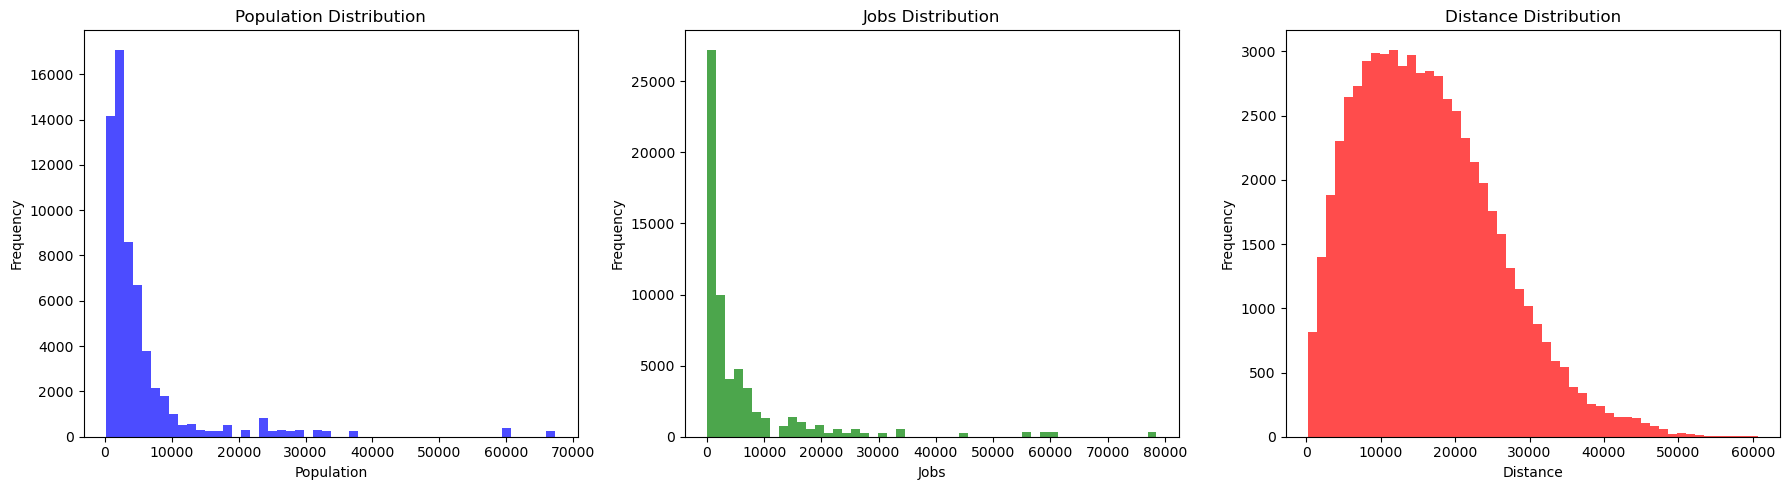

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(pre_df['population'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Population Distribution')
axes[0].set_xlabel('Population')
axes[0].set_ylabel('Frequency')

axes[1].hist(pre_df['jobs'], bins=50, color='green', alpha=0.7)
axes[1].set_title('Jobs Distribution')
axes[1].set_xlabel('Jobs')
axes[1].set_ylabel('Frequency')

axes[2].hist(pre_df['distance'], bins=50, color='red', alpha=0.7)
axes[2].set_title('Distance Distribution')
axes[2].set_xlabel('Distance')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

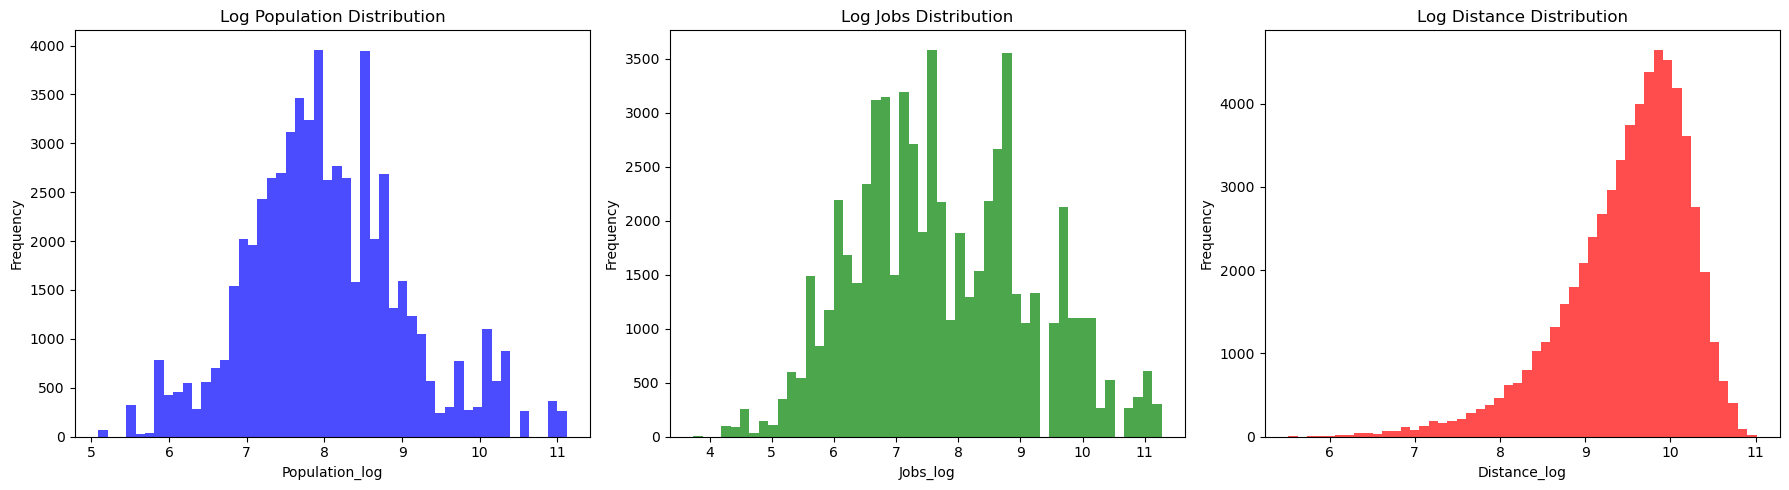

In [8]:
pre_df['population_log'] = np.log(pre_df['population'])
pre_df['jobs_log'] = np.log(pre_df['jobs'])
pre_df['distance_log'] = np.log(pre_df['distance'])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(pre_df['population_log'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Log Population Distribution')
axes[0].set_xlabel('Population_log')
axes[0].set_ylabel('Frequency')

axes[1].hist(pre_df['jobs_log'], bins=50, color='green', alpha=0.7)
axes[1].set_title('Log Jobs Distribution')
axes[1].set_xlabel('Jobs_log')
axes[1].set_ylabel('Frequency')

axes[2].hist(pre_df['distance_log'], bins=50, color='red', alpha=0.7)
axes[2].set_title('Log Distance Distribution')
axes[2].set_xlabel('Distance_log')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
pre_df.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576


In [10]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61413 entries, 0 to 61473
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61413 non-null  object 
 1   station_destination  61413 non-null  object 
 2   flows                61413 non-null  int64  
 3   population           61413 non-null  int64  
 4   jobs                 61413 non-null  int64  
 5   distance             61413 non-null  float64
 6   flows_s              61413 non-null  float64
 7   population_log       61413 non-null  float64
 8   jobs_log             61413 non-null  float64
 9   distance_log         61413 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 5.2+ MB


In [11]:
pivot = pd.pivot_table(pre_df, values ="flows_s", index="station_origin", columns ="station_destination",
                            aggfunc=np.sum, margins=True)

pivot_sort = pivot.T.sort_values(by='All', ascending=False).T

column_initial = pivot_sort.pop(pivot_sort.columns[0])

pivot_sort[column_initial.name] = column_initial

# Saving to excel
pivot_sort.to_excel("outputs/pivot_original.xlsx", index=True)

pivot_sort

/tmp/ipykernel_193/2421449630.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  pivot = pd.pivot_table(pre_df, values ="flows_s", index="station_origin", columns ="station_destination",
/tmp/ipykernel_193/2421449630.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  pivot = pd.pivot_table(pre_df, values ="flows_s", index="station_origin", columns ="station_destination",
/tmp/ipykernel_193/2421449630.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior 

station_destination,Bank and Monument,Liverpool Street,Canary Wharf,Stratford,Oxford Circus,King's Cross St. Pancras,Victoria,London Bridge,Green Park,Farringdon,...,West Harrow,Cheshunt,Theydon Bois,Hatch End,West Finchley,Beckton Park,Roding Valley,Grange Hill,Emerson Park,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0.001,NaN,1.000,285.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,599.004
Acton Central,NaN,NaN,NaN,11.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001,NaN,NaN,NaN,NaN,NaN,1224.024
Acton Town,66.000,55.000,57.000,10.000,38.000,64.000,53.000,39.000,79.000,19.000,...,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3745.052
Aldgate,5.000,67.000,1.000,6.000,15.000,351.000,5.000,2.000,3.000,677.000,...,2.000,NaN,NaN,NaN,0.001,NaN,NaN,NaN,NaN,2886.114
Aldgate East,95.000,47.000,3.000,82.000,50.000,111.000,31.000,25.000,46.000,140.000,...,NaN,NaN,0.001,NaN,0.001,NaN,0.001,0.001,NaN,3172.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,317.000,424.000,192.000,891.000,119.000,49.000,68.000,72.000,25.000,47.000,...,NaN,NaN,8.000,NaN,NaN,NaN,5.000,5.000,NaN,4868.025
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.013
Woodside Park,240.000,27.000,42.000,18.000,69.000,92.000,90.000,90.000,48.000,32.000,...,NaN,NaN,NaN,NaN,14.000,NaN,NaN,NaN,NaN,3093.029


In [12]:
rows_to_display = list(pivot_sort.index[:7]) + list(pivot_sort.index[-3:])
cols_to_display = list(pivot_sort.columns[:7]) + list(pivot_sort.columns[-3:])
pivot_display = pivot_sort.loc[rows_to_display, cols_to_display]

ellipsis_row = pd.DataFrame([["..."] * pivot_display.shape[1]], columns=pivot_display.columns, index=["..."])
ellipsis_col = pd.DataFrame({"...": ["..."] * (pivot_display.shape[0] + 1)}, index=pivot_display.index.tolist() + ["..."])

pivot_display = pd.concat([pivot_display.iloc[:7], ellipsis_row, pivot_display.iloc[-3:]])
pivot_display = pd.concat([pivot_display.iloc[:, :7], ellipsis_col, pivot_display.iloc[:, -3:]], axis=1)

pivot_display

,Bank and Monument,Liverpool Street,Canary Wharf,Stratford,Oxford Circus,King's Cross St. Pancras,Victoria,...,Grange Hill,Emerson Park,All
Abbey Road,0.001,NaN,1.0,285.0,NaN,NaN,NaN,...,NaN,NaN,599.004
Acton Central,NaN,NaN,NaN,11.0,NaN,NaN,NaN,...,NaN,NaN,1224.024
Acton Town,66.0,55.0,57.0,10.0,38.0,64.0,53.0,...,NaN,NaN,3745.052
Aldgate,5.0,67.0,1.0,6.0,15.0,351.0,5.0,...,NaN,NaN,2886.114
Aldgate East,95.0,47.0,3.0,82.0,50.0,111.0,31.0,...,0.001,NaN,3172.088
All Saints,93.0,NaN,67.0,258.0,NaN,NaN,NaN,...,NaN,NaN,740.005
Alperton,7.0,4.0,7.0,2.0,3.0,15.0,19.0,...,NaN,NaN,1624.036
...,...,...,...,...,...,...,...,...,...,...,...
Woodside Park,240.0,27.0,42.0,18.0,69.0,92.0,90.0,...,NaN,NaN,3093.029
Woolwich Arsenal,1340.0,NaN,82.0,1642.0,NaN,NaN,NaN,...,NaN,NaN,7892.002


## Model selection

Production-Constrained Gravity Model

### Calibration parameter

#### Inverse power function

In [13]:
df_flows = pre_df.copy()

In [14]:
df_flows.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576


In [15]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [16]:
#show the actual flows between boroughs
df_flows_pivot = pd.pivot_table(df_flows, values ="flows_s", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
#show the data
df_flows_pivot

/tmp/ipykernel_193/4037343811.py:2: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df_flows_pivot = pd.pivot_table(df_flows, values ="flows_s", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/4037343811.py:2: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df_flows_pivot = pd.pivot_table(df_flows, values ="flows_s", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/4037343811.py:2: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. T

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.000,599.004
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN,NaN,1224.024
Acton Town,NaN,NaN,NaN,3.000,17.000,NaN,35.000,0.001,NaN,11.00,...,77.000,3.000,6.000,9.000,NaN,0.001,NaN,0.001,NaN,3745.052
Aldgate,NaN,NaN,0.001,NaN,0.001,NaN,NaN,0.001,NaN,17.00,...,0.001,NaN,4.000,8.000,NaN,0.001,NaN,0.001,NaN,2886.114
Aldgate East,NaN,NaN,2.000,0.001,NaN,NaN,0.001,0.001,NaN,20.00,...,24.000,0.001,0.001,12.000,NaN,1.000,NaN,1.000,NaN,3172.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.000,5.000,47.000,NaN,NaN,NaN,NaN,22.00,...,2.000,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,4868.025
Woodgrange Park,NaN,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.013
Woodside Park,NaN,NaN,1.000,26.000,11.000,NaN,0.001,NaN,NaN,59.00,...,0.001,NaN,0.001,NaN,NaN,NaN,NaN,NaN,NaN,3093.029


In [17]:
df_flows_pivot_sort = df_flows_pivot.T.sort_values(by='All', ascending=False).T

column_1 = df_flows_pivot_sort.pop(df_flows_pivot_sort.columns[0])
df_flows_pivot_sort[column_1.name] = column_1

df_flows_pivot_sort

/tmp/ipykernel_193/956064887.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_flows_pivot_sort[column_1.name] = column_1


station_destination,Bank and Monument,Liverpool Street,Canary Wharf,Stratford,Oxford Circus,King's Cross St. Pancras,Victoria,London Bridge,Green Park,Farringdon,...,West Harrow,Cheshunt,Theydon Bois,Hatch End,West Finchley,Beckton Park,Roding Valley,Grange Hill,Emerson Park,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0.001,NaN,1.000,285.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,599.004
Acton Central,NaN,NaN,NaN,11.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001,NaN,NaN,NaN,NaN,NaN,1224.024
Acton Town,66.000,55.000,57.000,10.000,38.000,64.000,53.000,39.000,79.000,19.000,...,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3745.052
Aldgate,5.000,67.000,1.000,6.000,15.000,351.000,5.000,2.000,3.000,677.000,...,2.000,NaN,NaN,NaN,0.001,NaN,NaN,NaN,NaN,2886.114
Aldgate East,95.000,47.000,3.000,82.000,50.000,111.000,31.000,25.000,46.000,140.000,...,NaN,NaN,0.001,NaN,0.001,NaN,0.001,0.001,NaN,3172.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,317.000,424.000,192.000,891.000,119.000,49.000,68.000,72.000,25.000,47.000,...,NaN,NaN,8.000,NaN,NaN,NaN,5.000,5.000,NaN,4868.025
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.013
Woodside Park,240.000,27.000,42.000,18.000,69.000,92.000,90.000,90.000,48.000,32.000,...,NaN,NaN,NaN,NaN,14.000,NaN,NaN,NaN,NaN,3093.029


In [18]:
last_row = df_flows_pivot_sort.iloc[-1][:-1]

In [19]:
last_row

station_destination
Bank and Monument    78549.006
Liverpool Street     61122.008
Canary Wharf         58772.009
Stratford            55954.034
Oxford Circus        44368.003
                       ...    
West Finchley           91.094
Beckton Park            88.011
Roding Valley           84.041
Grange Hill             76.075
Emerson Park            42.000
Name: All, Length: 398, dtype: float64

In [20]:
unique_categories_array = df_flows['station_origin'].unique()
num_unique_categories = len(unique_categories_array)
num_unique_categories

398

In [21]:
unique_categories_array = df_flows['station_destination'].unique()
num_unique_categories = len(unique_categories_array)
num_unique_categories

398

In [22]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows_s ~ station_origin +jobs_log + distance_log - 1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=df_flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                flows_s   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Sat, 25 May 2024   Deviance:                   1.8612e+06
Time:                        11:47:13   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

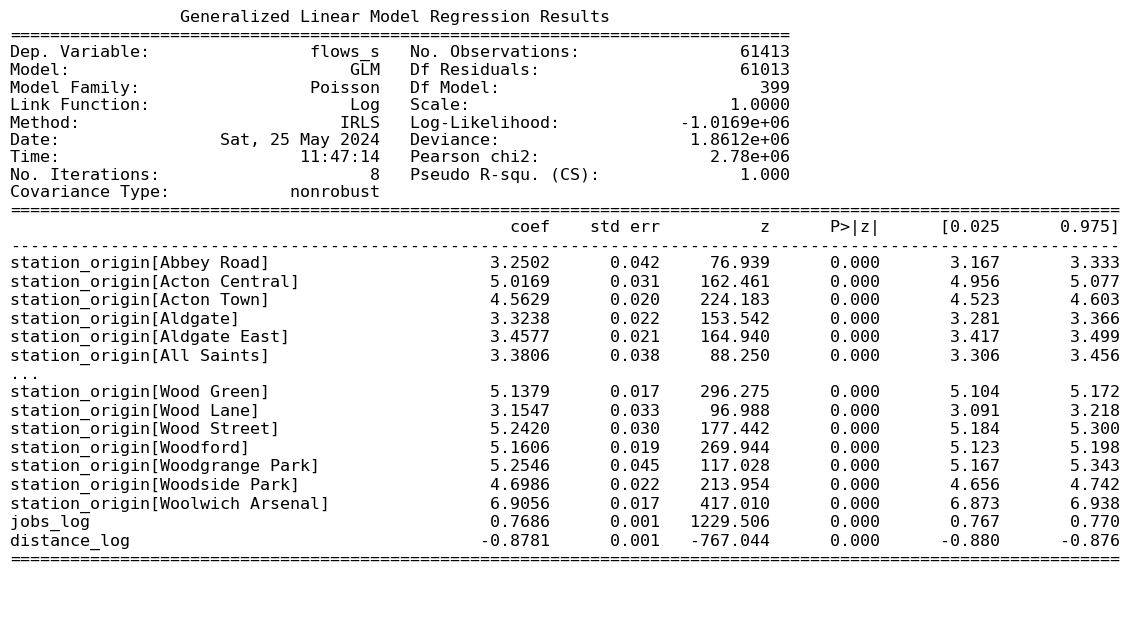

In [23]:
summary_str = prodSim.summary().as_text()

summary_lines = summary_str.split('\n')

selected_lines = summary_lines[:20] + ['...'] + summary_lines[-10:]

fig, ax = plt.subplots(figsize=(10, 8))

ax.axis('off')

text = "\n".join(selected_lines)
ax.text(0, 1, text, va='top', ha='left', fontsize=12, family='monospace')

plt.savefig('outputs/Inverse_Power.png', bbox_inches='tight')

plt.show()

In [24]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i_1 = pd.DataFrame(df_flows.groupby(["station_origin"])["flows_s"].agg(np.sum))
O_i_1.rename(columns={"flows_s":"O_i_1"}, inplace = True)
df_flows = df_flows.merge(O_i_1, on = "station_origin", how = "left" )

D_j_1 = pd.DataFrame(df_flows.groupby(["station_destination"])["flows_s"].agg(np.sum))
D_j_1.rename(columns={"flows_s":"D_j_1"}, inplace = True)
df_flows =df_flows.merge(D_j_1, on = "station_destination", how = "left" )

/tmp/ipykernel_193/2686280385.py:3: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  O_i_1 = pd.DataFrame(df_flows.groupby(["station_origin"])["flows_s"].agg(np.sum))
/tmp/ipykernel_193/2686280385.py:7: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  D_j_1 = pd.DataFrame(df_flows.groupby(["station_destination"])["flows_s"].agg(np.sum))


In [25]:
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i_1", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
coefs

,coef,alpha_i_1
0,Abbey Road,3.250249
1,Acton Central,5.016867
2,Acton Town,4.562856
3,Aldgate,3.323798
4,Aldgate East,3.457679
...,...,...
395,Woodgrange Park,5.254630
396,Woodside Park,4.698591
397,Woolwich Arsenal,6.905551
398,jobs_log,0.768599


In [26]:
df_flows = df_flows.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
df_flows.drop(columns = ["coef"], inplace = True)
df_flows.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,O_i_1,D_j_1,alpha_i_1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,599.004,78549.006,3.250249
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,599.004,442.011,3.250249
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,599.004,665.005,3.250249
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,599.004,58772.009,3.250249
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,599.004,15428.037,3.250249
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,599.004,1208.004,3.250249
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,599.004,845.015,3.250249
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,599.004,1748.002,3.250249
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,599.004,850.006,3.250249
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,599.004,611.005,3.250249


In [27]:
alpha_i = prodSim.params[0:398]
gamma = prodSim.params[398]
beta = -prodSim.params[399]

/tmp/ipykernel_193/3439944073.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = prodSim.params[398]
/tmp/ipykernel_193/3439944073.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -prodSim.params[399]


In [28]:
alpha_i

station_origin[Abbey Road]          3.250249
station_origin[Acton Central]       5.016867
station_origin[Acton Town]          4.562856
station_origin[Aldgate]             3.323798
station_origin[Aldgate East]        3.457679
                                      ...   
station_origin[Wood Street]         5.242000
station_origin[Woodford]            5.160593
station_origin[Woodgrange Park]     5.254630
station_origin[Woodside Park]       4.698591
station_origin[Woolwich Arsenal]    6.905551
Length: 398, dtype: float64

In [29]:
gamma

0.7685989966422341

In [30]:
beta

0.8780975513417705

In [31]:
df_flows["prodsimest_1"] = np.exp(df_flows["alpha_i_1"]+gamma*df_flows["jobs_log"] 
                                 - beta*df_flows["distance_log"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
df_flows.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,O_i_1,D_j_1,alpha_i_1,prodsimest_1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,599.004,78549.006,3.250249,55.011438
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,599.004,442.011,3.250249,0.986205
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,599.004,665.005,3.250249,2.755851
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,599.004,58772.009,3.250249,66.457859
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,599.004,15428.037,3.250249,49.061603
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,599.004,1208.004,3.250249,2.639626
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,599.004,845.015,3.250249,3.275359
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,599.004,1748.002,3.250249,2.839170
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,599.004,850.006,3.250249,2.056483
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,599.004,611.005,3.250249,2.477124


In [32]:
#first round the estimates
df_flows["prodsimest_1"] = round(df_flows["prodsimest_1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
df_flows_pivot_prodsimest_1 = df_flows.pivot_table(values ="prodsimest_1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
df_flows_pivot_prodsimest_1

/tmp/ipykernel_193/3137571142.py:4: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df_flows_pivot_prodsimest_1 = df_flows.pivot_table(values ="prodsimest_1", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/3137571142.py:4: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df_flows_pivot_prodsimest_1 = df_flows.pivot_table(values ="prodsimest_1", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/3137571142.py:4: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided calla

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3749.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [33]:
CalcRSquared(df_flows["flows_s"], df_flows["prodsimest_1"])

0.38827574549931576

In [34]:
CalcRMSE(df_flows["flows_s"], df_flows["prodsimest_1"])

102.893

#### Negative exponential function

In [35]:
formula = 'flows_s ~ station_origin + jobs_log + distance-1' 
#run a production constrained sim
prodSim_2 = smf.glm(formula = formula, data=df_flows, family=sm.families.Poisson()).fit()
print(prodSim_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                flows_s   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Sat, 25 May 2024   Deviance:                   1.6474e+06
Time:                        11:48:53   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

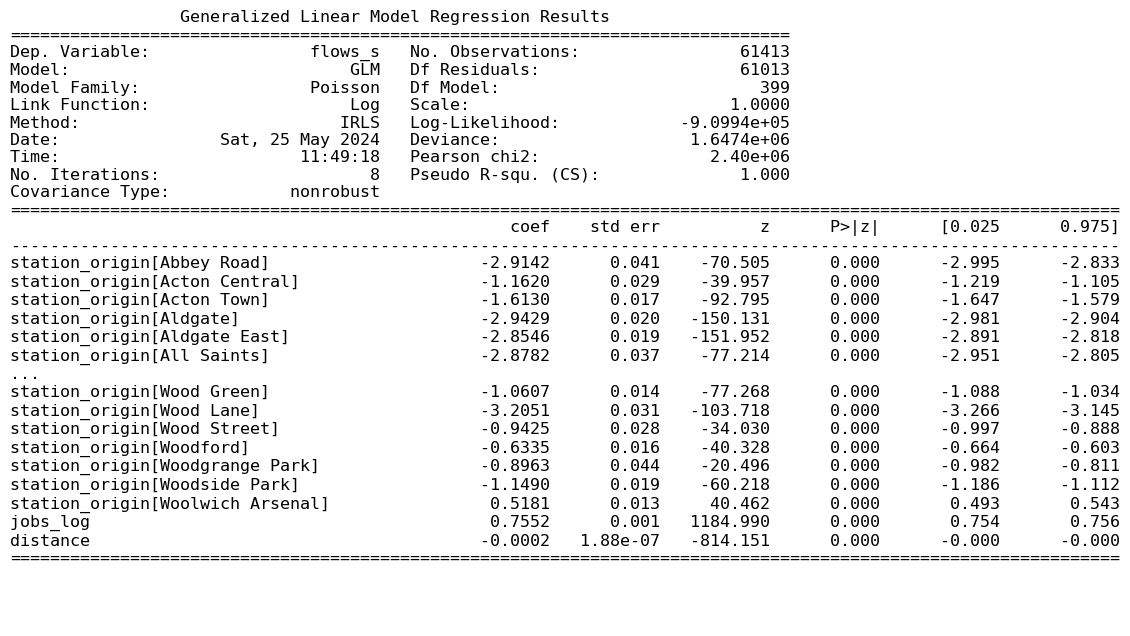

In [36]:
summary_str_2 = prodSim_2.summary().as_text()

summary_lines_2 = summary_str_2.split('\n')

selected_lines_2 = summary_lines_2[:20] + ['...'] + summary_lines_2[-10:]

fig, ax = plt.subplots(figsize=(10, 8))

ax.axis('off')

text_2 = "\n".join(selected_lines_2)
ax.text(0, 1, text_2, va='top', ha='left', fontsize=12, family='monospace')

plt.savefig('outputs/Negative_exponential.png', bbox_inches='tight')

plt.show()

In [37]:
coefs_2 = pd.DataFrame(prodSim_2.params)
coefs_2.reset_index(inplace=True)
coefs_2.rename(columns = {0:"alpha_i_2", "index":"coef_2"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs_2["coef_2"] = coefs_2["coef_2"].str.replace(x, "",regex=True)
coefs_2

,coef_2,alpha_i_2
0,Abbey Road,-2.914156
1,Acton Central,-1.161982
2,Acton Town,-1.612978
3,Aldgate,-2.942859
4,Aldgate East,-2.854576
...,...,...
395,Woodgrange Park,-0.896306
396,Woodside Park,-1.149038
397,Woolwich Arsenal,0.518148
398,jobs_log,0.755202


In [38]:
df_flows = df_flows.merge(coefs_2, left_on="station_origin", right_on="coef_2", how = "left")
df_flows.drop(columns = ["coef_2"], inplace = True)
df_flows.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,O_i_1,D_j_1,alpha_i_1,prodsimest_1,alpha_i_2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,599.004,78549.006,3.250249,55.0,-2.914156
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,599.004,442.011,3.250249,1.0,-2.914156
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,599.004,665.005,3.250249,3.0,-2.914156
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,599.004,58772.009,3.250249,66.0,-2.914156
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,599.004,15428.037,3.250249,49.0,-2.914156
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,599.004,1208.004,3.250249,3.0,-2.914156
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,599.004,845.015,3.250249,3.0,-2.914156
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,599.004,1748.002,3.250249,3.0,-2.914156
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,599.004,850.006,3.250249,2.0,-2.914156
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,599.004,611.005,3.250249,2.0,-2.914156


In [39]:
alpha_i_2 = prodSim_2.params[0:398]
gamma_2 = prodSim_2.params[398]
beta_2 = -prodSim_2.params[399]

/tmp/ipykernel_193/1631242316.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma_2 = prodSim_2.params[398]
/tmp/ipykernel_193/1631242316.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_2 = -prodSim_2.params[399]


In [40]:
alpha_i_2

station_origin[Abbey Road]         -2.914156
station_origin[Acton Central]      -1.161982
station_origin[Acton Town]         -1.612978
station_origin[Aldgate]            -2.942859
station_origin[Aldgate East]       -2.854576
                                      ...   
station_origin[Wood Street]        -0.942505
station_origin[Woodford]           -0.633533
station_origin[Woodgrange Park]    -0.896306
station_origin[Woodside Park]      -1.149038
station_origin[Woolwich Arsenal]    0.518148
Length: 398, dtype: float64

In [41]:
gamma_2

0.7552024675542629

In [42]:
beta_2

0.00015315869998733822

In [43]:
df_flows["prodsimest_2"] = np.exp(df_flows["alpha_i_2"]+gamma_2*df_flows["jobs_log"]
                                 - beta_2*df_flows["distance"])
df_flows.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,O_i_1,D_j_1,alpha_i_1,prodsimest_1,alpha_i_2,prodsimest_2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,599.004,78549.006,3.250249,55.0,-2.914156,77.686224
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,599.004,442.011,3.250249,1.0,-2.914156,1.466116
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,599.004,665.005,3.250249,3.0,-2.914156,4.121661
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,599.004,58772.009,3.250249,66.0,-2.914156,99.483920
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,599.004,15428.037,3.250249,49.0,-2.914156,56.125577
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,599.004,1208.004,3.250249,3.0,-2.914156,4.142144
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,599.004,845.015,3.250249,3.0,-2.914156,4.901776
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,599.004,1748.002,3.250249,3.0,-2.914156,4.145035
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,599.004,850.006,3.250249,2.0,-2.914156,3.252471
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,599.004,611.005,3.250249,2.0,-2.914156,3.759512


In [44]:
CalcRSquared(df_flows["flows_s"], df_flows["prodsimest_2"])

0.4680632561649096

In [45]:
CalcRMSE(df_flows["flows_s"], df_flows["prodsimest_2"])

96.264

### Scenario A

In [46]:
df_flows_a = df_flows.copy()

In [47]:
df_flows_a.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,O_i_1,D_j_1,alpha_i_1,prodsimest_1,alpha_i_2,prodsimest_2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,599.004,78549.006,3.250249,55.0,-2.914156,77.686224
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,599.004,442.011,3.250249,1.0,-2.914156,1.466116
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,599.004,665.005,3.250249,3.0,-2.914156,4.121661
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,599.004,58772.009,3.250249,66.0,-2.914156,99.483920
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,599.004,15428.037,3.250249,49.0,-2.914156,56.125577
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,599.004,1208.004,3.250249,3.0,-2.914156,4.142144
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,599.004,845.015,3.250249,3.0,-2.914156,4.901776
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,599.004,1748.002,3.250249,3.0,-2.914156,4.145035
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,599.004,850.006,3.250249,2.0,-2.914156,3.252471
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,599.004,611.005,3.250249,2.0,-2.914156,3.759512


#### Test

In [48]:
#重新测试的数据应该使用原始的jobs
Dj_gamma_t = df_flows_a["jobs"]**gamma_2
dist_beta_t = np.exp(df_flows_a['distance']* (-beta_2))#负指数
#calcualte the first stage of the Ai values
df_flows_a["Ait"] = Dj_gamma_t * dist_beta_t
df_flows_a.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,O_i_1,D_j_1,alpha_i_1,prodsimest_1,alpha_i_2,prodsimest_2,Ait
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,599.004,78549.006,3.250249,55.0,-2.914156,77.686224,1432.009698
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,599.004,442.011,3.250249,1.0,-2.914156,1.466116,27.025289
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,599.004,665.005,3.250249,3.0,-2.914156,4.121661,75.975610
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,599.004,58772.009,3.250249,66.0,-2.914156,99.483920,1833.812116
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,599.004,15428.037,3.250249,49.0,-2.914156,56.125577,1034.576865
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,599.004,1208.004,3.250249,3.0,-2.914156,4.142144,76.353173
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,599.004,845.015,3.250249,3.0,-2.914156,4.901776,90.355667
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,599.004,1748.002,3.250249,3.0,-2.914156,4.145035,76.406470
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,599.004,850.006,3.250249,2.0,-2.914156,3.252471,59.953619
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,599.004,611.005,3.250249,2.0,-2.914156,3.759512,69.300025


In [49]:
#now do the sum over all js bit
A_i_t = pd.DataFrame(df_flows_a.groupby(["station_origin"])["Ait"].agg(np.sum))
#now divide into 1
A_i_t["Ait"] = 1/A_i_t["Ait"]
A_i_t.rename(columns={"Ait":"A_i_t"}, inplace=True)
#and write the A_i values back into the dataframe
A_i_t

/tmp/ipykernel_193/716018743.py:2: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i_t = pd.DataFrame(df_flows_a.groupby(["station_origin"])["Ait"].agg(np.sum))


,A_i_t
station_origin,
Abbey Road,0.000091
Acton Central,0.000256
Acton Town,0.000053
Aldgate,0.000018
Aldgate East,0.000018
...,...
Wood Street,0.000285
Woodford,0.000109
Woodgrange Park,0.000770


In [50]:
df_flows_a = df_flows_a.merge(A_i_t, left_on="station_origin", right_index=True, how="left")

df_flows_a.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,O_i_1,D_j_1,alpha_i_1,prodsimest_1,alpha_i_2,prodsimest_2,Ait,A_i_t
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,599.004,78549.006,3.250249,55.0,-2.914156,77.686224,1432.009698,0.000091
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,599.004,442.011,3.250249,1.0,-2.914156,1.466116,27.025289,0.000091
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,599.004,665.005,3.250249,3.0,-2.914156,4.121661,75.975610,0.000091
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,599.004,58772.009,3.250249,66.0,-2.914156,99.483920,1833.812116,0.000091
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,599.004,15428.037,3.250249,49.0,-2.914156,56.125577,1034.576865,0.000091
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,599.004,1208.004,3.250249,3.0,-2.914156,4.142144,76.353173,0.000091
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,599.004,845.015,3.250249,3.0,-2.914156,4.901776,90.355667,0.000091
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,599.004,1748.002,3.250249,3.0,-2.914156,4.145035,76.406470,0.000091
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,599.004,850.006,3.250249,2.0,-2.914156,3.252471,59.953619,0.000091
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,599.004,611.005,3.250249,2.0,-2.914156,3.759512,69.300025,0.000091


In [51]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i_t = pd.DataFrame(df_flows_a.groupby(["station_origin"])["flows_s"].agg(np.sum))
O_i_t.rename(columns={"flows_s":"O_i_t"}, inplace = True)
df_flows_a = df_flows_a.merge(O_i_t, on = "station_origin", how = "left" )

D_j_t = pd.DataFrame(df_flows_a.groupby(["station_destination"])["flows_s"].agg(np.sum))
D_j_t.rename(columns={"flows_s":"D_j_t"}, inplace = True)
df_flows_a = df_flows_a.merge(D_j_t, on = "station_destination", how = "left" )
df_flows_a.head(10)

/tmp/ipykernel_193/3263719354.py:3: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  O_i_t = pd.DataFrame(df_flows_a.groupby(["station_origin"])["flows_s"].agg(np.sum))
/tmp/ipykernel_193/3263719354.py:7: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  D_j_t = pd.DataFrame(df_flows_a.groupby(["station_destination"])["flows_s"].agg(np.sum))


,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,O_i_1,D_j_1,alpha_i_1,prodsimest_1,alpha_i_2,prodsimest_2,Ait,A_i_t,O_i_t,D_j_t
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,599.004,78549.006,3.250249,55.0,-2.914156,77.686224,1432.009698,0.000091,599.004,78549.006
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,599.004,442.011,3.250249,1.0,-2.914156,1.466116,27.025289,0.000091,599.004,442.011
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,599.004,665.005,3.250249,3.0,-2.914156,4.121661,75.975610,0.000091,599.004,665.005
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,599.004,58772.009,3.250249,66.0,-2.914156,99.483920,1833.812116,0.000091,599.004,58772.009
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,599.004,15428.037,3.250249,49.0,-2.914156,56.125577,1034.576865,0.000091,599.004,15428.037
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,599.004,1208.004,3.250249,3.0,-2.914156,4.142144,76.353173,0.000091,599.004,1208.004
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,599.004,845.015,3.250249,3.0,-2.914156,4.901776,90.355667,0.000091,599.004,845.015
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,599.004,1748.002,3.250249,3.0,-2.914156,4.145035,76.406470,0.000091,599.004,1748.002
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,599.004,850.006,3.250249,2.0,-2.914156,3.252471,59.953619,0.000091,599.004,850.006
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,599.004,611.005,3.250249,2.0,-2.914156,3.759512,69.300025,0.000091,599.004,611.005


In [52]:
df_flows_a["prodsimest_t"] = df_flows_a["A_i_t"]*df_flows_a["O_i_t"]*Dj_gamma_t*dist_beta_t #这里的Dj2_gamma用的是原来的jobs
#round
df_flows_a["prodsimest_t"] = round(df_flows_a["prodsimest_t"],6)
#check
df_flows_a[["prodsimest_2", "prodsimest_t"]]

,prodsimest_2,prodsimest_t
0,77.686224,77.686224
1,1.466116,1.466116
2,4.121661,4.121661
3,99.483920,99.483920
4,56.125577,56.125577
...,...,...
61408,98.840225,98.840225
61409,295.255599,295.255599
61410,35.955616,35.955616
61411,125.115066,125.115066


In [53]:
test_pivot = df_flows_a.pivot_table(values ="prodsimest_t", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
test_pivot

/tmp/ipykernel_193/2930502454.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  test_pivot = df_flows_a.pivot_table(values ="prodsimest_t", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/2930502454.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  test_pivot = df_flows_a.pivot_table(values ="prodsimest_t", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/2930502454.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To 

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.477015,5.990040e+02
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.330409,NaN,NaN,1.224024e+03
Acton Town,NaN,NaN,NaN,12.912317,12.623097,NaN,13.677182,0.042345,NaN,15.949812,...,13.336680,2.897705,1.918252,19.610024,NaN,0.225833,NaN,0.539231,NaN,3.745052e+03
Aldgate,NaN,NaN,1.316395,NaN,37.257281,NaN,NaN,0.003403,NaN,27.474336,...,2.097842,NaN,2.495728,2.047121,NaN,0.664839,NaN,0.545809,NaN,2.886114e+03
Aldgate East,NaN,NaN,1.385565,40.113453,NaN,NaN,0.284202,0.003581,NaN,28.910291,...,2.208073,0.479755,2.626168,2.154114,NaN,0.904904,NaN,0.574336,NaN,3.172088e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.419822,40.999768,51.830820,NaN,NaN,NaN,NaN,30.213454,...,2.262666,NaN,5.713176,NaN,NaN,NaN,NaN,NaN,NaN,4.868025e+03
Woodgrange Park,NaN,1.012565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.300130e+02
Woodside Park,NaN,NaN,1.944045,19.301427,18.864086,NaN,0.398755,NaN,NaN,31.515991,...,3.098081,NaN,3.790365,NaN,NaN,NaN,NaN,NaN,NaN,3.093029e+03


In [54]:
test_pivot_sort = test_pivot.T.sort_values(by='All', ascending=False).T

column_t = test_pivot_sort.pop(test_pivot_sort.columns[0])
test_pivot_sort[column_t.name] = column_t

# Saving to excel
test_pivot_sort.to_excel("test_pivot.xlsx", index=True)

test_pivot_sort

/tmp/ipykernel_193/2678236750.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_pivot_sort[column_t.name] = column_t


station_destination,Bank and Monument,Stratford,Liverpool Street,Canary Wharf,Oxford Circus,King's Cross St. Pancras,Highbury & Islington,Victoria,London Bridge,Green Park,...,Grange Hill,Ruislip Gardens,Beckton Park,Theydon Bois,South Hampstead,Hatch End,West Ruislip,Cheshunt,Emerson Park,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,77.686224,174.521152,NaN,99.483920,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.990040e+02
Acton Central,NaN,39.898406,NaN,NaN,NaN,NaN,68.266744,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.830271,0.843844,NaN,NaN,NaN,1.224024e+03
Acton Town,92.223740,22.493971,67.080340,35.024988,100.769517,55.603616,30.483141,99.451231,50.212717,80.286822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.745052e+03
Aldgate,210.463602,66.221002,194.290124,77.087358,72.060152,72.342701,39.659880,53.274711,88.662490,47.024775,...,NaN,0.040669,NaN,NaN,NaN,NaN,0.032894,NaN,NaN,2.886114e+03
Aldgate East,221.522391,90.132480,204.444754,104.922524,75.846545,76.123714,41.732715,56.074026,93.321252,49.495687,...,0.079028,NaN,NaN,0.047225,NaN,NaN,0.034622,NaN,NaN,3.172088e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,226.999352,557.576142,213.660328,249.881585,77.721789,81.690662,98.763859,57.460410,95.628544,50.719428,...,6.568468,NaN,NaN,3.925148,NaN,NaN,NaN,NaN,NaN,4.868025e+03
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.300130e+02
Woodside Park,117.241763,35.203146,102.236520,41.266693,120.039189,109.869825,60.233085,68.714118,49.390710,70.177922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.093029e+03


#### Jobs-50%

In [55]:
def jobs_new(row):
    if row['station_destination'] == 'Canary Wharf':
        jobs_new = row['jobs'] * 0.5
    else:
        jobs_new = row["jobs"]
    return jobs_new
        
df_flows_a["jobs_dec"] = df_flows_a.apply(jobs_new, axis =1)

In [56]:
#calculate some new Dj^gamma and d_ij^beta values
Dj_gamma_a = df_flows_a["jobs_dec"]**gamma_2
#calcualte the first stage of the Ai values
df_flows_a["Ait"] = Dj_gamma_a * dist_beta_t
#now do the sum over all js bit
A_i_a = pd.DataFrame(df_flows_a.groupby(["station_origin"])["Ait"].agg(np.sum))
#now divide into 1
A_i_a["Ait"] = 1/A_i_a["Ait"]
A_i_a.rename(columns={"Ait":"A_i_a"}, inplace=True)
#and write the A_i values back into the dataframe
df_flows_a = df_flows_a.merge(A_i_a, left_on="station_origin", right_index=True, how="left")
df_flows_a.head(10)

/tmp/ipykernel_193/1519826110.py:6: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i_a = pd.DataFrame(df_flows_a.groupby(["station_origin"])["Ait"].agg(np.sum))


,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,...,prodsimest_1,alpha_i_2,prodsimest_2,Ait,A_i_t,O_i_t,D_j_t,prodsimest_t,jobs_dec,A_i_a
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,55.0,-2.914156,77.686224,1432.009698,0.000091,599.004,78549.006,77.686224,78549.0,0.000097
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,1.0,-2.914156,1.466116,27.025289,0.000091,599.004,442.011,1.466116,442.0,0.000097
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,...,3.0,-2.914156,4.121661,75.975610,0.000091,599.004,665.005,4.121661,665.0,0.000097
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,...,66.0,-2.914156,99.483920,1086.466256,0.000091,599.004,58772.009,99.483920,29386.0,0.000097
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,...,49.0,-2.914156,56.125577,1034.576865,0.000091,599.004,15428.037,56.125577,15428.0,0.000097
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,...,3.0,-2.914156,4.142144,76.353173,0.000091,599.004,1208.004,4.142144,1208.0,0.000097
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,...,3.0,-2.914156,4.901776,90.355667,0.000091,599.004,845.015,4.901776,845.0,0.000097
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,...,3.0,-2.914156,4.145035,76.406470,0.000091,599.004,1748.002,4.145035,1748.0,0.000097
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,...,2.0,-2.914156,3.252471,59.953619,0.000091,599.004,850.006,3.252471,850.0,0.000097
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,...,2.0,-2.914156,3.759512,69.300025,0.000091,599.004,611.005,3.759512,611.0,0.000097


In [57]:
df_flows_a["prodsimest_jobs_dec"] = df_flows_a["A_i_a"]*df_flows_a["O_i_t"]*Dj_gamma_a*dist_beta_t
df_flows_a["prodsimest_jobs_dec"] = round(df_flows_a["prodsimest_jobs_dec"],2)    

In [58]:
job_dec_pivot = df_flows_a.pivot_table(values ="prodsimest_jobs_dec", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
job_dec_pivot

/tmp/ipykernel_193/1048710224.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  job_dec_pivot = df_flows_a.pivot_table(values ="prodsimest_jobs_dec", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/1048710224.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  job_dec_pivot = df_flows_a.pivot_table(values ="prodsimest_jobs_dec", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/1048710224.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will b

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.02,599.02
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.33,NaN,NaN,1224.05
Acton Town,NaN,NaN,NaN,12.96,12.67,NaN,13.73,0.04,NaN,16.01,...,13.39,2.91,1.93,19.69,NaN,0.23,NaN,0.54,NaN,3745.11
Aldgate,NaN,NaN,1.33,NaN,37.67,NaN,NaN,0.00,NaN,27.78,...,2.12,NaN,2.52,2.07,NaN,0.67,NaN,0.55,NaN,2886.10
Aldgate East,NaN,NaN,1.40,40.66,NaN,NaN,0.29,0.00,NaN,29.31,...,2.24,0.49,2.66,2.18,NaN,0.92,NaN,0.58,NaN,3172.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.45,41.88,52.94,NaN,NaN,NaN,NaN,30.86,...,2.31,NaN,5.84,NaN,NaN,NaN,NaN,NaN,NaN,4868.09
Woodgrange Park,NaN,1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.99
Woodside Park,NaN,NaN,1.95,19.41,18.97,NaN,0.40,NaN,NaN,31.69,...,3.12,NaN,3.81,NaN,NaN,NaN,NaN,NaN,NaN,3093.01


In [59]:
job_dec_pivot_sort = job_dec_pivot.T.sort_values(by='All', ascending=False).T

column_dec = job_dec_pivot_sort.pop(job_dec_pivot_sort.columns[0])
job_dec_pivot_sort[column_dec.name] = column_dec

# Saving to excel
job_dec_pivot_sort.to_excel("pivot_decrease.xlsx", index=True)

job_dec_pivot_sort

/tmp/ipykernel_193/3015895806.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  job_dec_pivot_sort[column_dec.name] = column_dec


station_destination,Bank and Monument,Stratford,Liverpool Street,Oxford Circus,King's Cross St. Pancras,Highbury & Islington,Canary Wharf,Victoria,London Bridge,Green Park,...,Beckton Park,Grange Hill,Ruislip Gardens,Theydon Bois,South Hampstead,Hatch End,West Ruislip,Cheshunt,Emerson Park,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,83.33,187.19,NaN,NaN,NaN,NaN,63.22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,599.02
Acton Central,NaN,39.90,NaN,NaN,NaN,68.27,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.83,0.84,NaN,NaN,NaN,1224.05
Acton Town,92.58,22.58,67.34,101.16,55.82,30.60,20.83,99.83,50.40,80.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3745.11
Aldgate,212.78,66.95,196.43,72.85,73.14,40.10,46.17,53.86,89.64,47.54,...,NaN,NaN,0.04,NaN,NaN,NaN,0.03,NaN,NaN,2886.10
Aldgate East,224.55,91.36,207.24,76.88,77.16,42.30,63.01,56.84,94.60,50.17,...,NaN,0.08,NaN,0.05,NaN,NaN,0.04,NaN,NaN,3172.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,231.85,569.49,218.23,79.38,83.44,100.87,151.21,58.69,97.67,51.80,...,NaN,6.71,NaN,4.01,NaN,NaN,NaN,NaN,NaN,4868.09
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.99
Woodside Park,117.88,35.40,102.80,120.70,110.47,60.56,24.58,69.09,49.66,70.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093.01


In [60]:
rows_to_display_dec = list(job_dec_pivot_sort.index[:7]) + list(job_dec_pivot_sort.index[-3:])
cols_to_display_dec = list(job_dec_pivot_sort.columns[:7]) + list(job_dec_pivot_sort.columns[-3:])
pivot_display_dec = job_dec_pivot_sort.loc[rows_to_display_dec, cols_to_display_dec]

ellipsis_row_dec = pd.DataFrame([["..."] * pivot_display_dec.shape[1]], columns=pivot_display_dec.columns, index=["..."])
ellipsis_col_dec = pd.DataFrame({"...": ["..."] * (pivot_display_dec.shape[0] + 1)}, index=pivot_display_dec.index.tolist() + ["..."])

pivot_display_dec = pd.concat([pivot_display_dec.iloc[:7], ellipsis_row_dec, pivot_display_dec.iloc[-3:]])
pivot_display_dec = pd.concat([pivot_display_dec.iloc[:, :7], ellipsis_col_dec, pivot_display_dec.iloc[:, -3:]], axis=1)

pivot_display_dec

,Bank and Monument,Stratford,Liverpool Street,Oxford Circus,King's Cross St. Pancras,Highbury & Islington,Canary Wharf,...,Cheshunt,Emerson Park,All
Abbey Road,83.33,187.19,NaN,NaN,NaN,NaN,63.22,...,NaN,NaN,599.02
Acton Central,NaN,39.9,NaN,NaN,NaN,68.27,NaN,...,NaN,NaN,1224.05
Acton Town,92.58,22.58,67.34,101.16,55.82,30.6,20.83,...,NaN,NaN,3745.11
Aldgate,212.78,66.95,196.43,72.85,73.14,40.1,46.17,...,NaN,NaN,2886.1
Aldgate East,224.55,91.36,207.24,76.88,77.16,42.3,63.01,...,NaN,NaN,3172.07
All Saints,125.71,127.71,NaN,NaN,NaN,NaN,120.61,...,NaN,NaN,740.01
Alperton,41.48,10.12,30.17,45.33,25.01,13.71,9.33,...,NaN,NaN,1623.98
...,...,...,...,...,...,...,...,...,...,...,...
Woodside Park,117.88,35.4,102.8,120.7,110.47,60.56,24.58,...,NaN,NaN,3093.01
Woolwich Arsenal,990.4,1429.09,NaN,NaN,NaN,NaN,950.22,...,NaN,NaN,7891.99


### Scenario B

#### Beta Change

In [61]:
df_flows_b = df_flows_a.copy()

In [62]:
beta_2

0.00015315869998733822

In [63]:
# short
beta_s = beta_2*3
# long
beta_l = beta_2*6

In [64]:
beta_s

0.0004594760999620147

In [65]:
beta_l

0.0009189521999240294

In [66]:
df_flows_b.head()

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,...,alpha_i_2,prodsimest_2,Ait,A_i_t,O_i_t,D_j_t,prodsimest_t,jobs_dec,A_i_a,prodsimest_jobs_dec
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,-2.914156,77.686224,1432.009698,0.000091,599.004,78549.006,77.686224,78549.0,0.000097,83.33
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,-2.914156,1.466116,27.025289,0.000091,599.004,442.011,1.466116,442.0,0.000097,1.57
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,...,-2.914156,4.121661,75.975610,0.000091,599.004,665.005,4.121661,665.0,0.000097,4.42
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,...,-2.914156,99.483920,1086.466256,0.000091,599.004,58772.009,99.483920,29386.0,0.000097,63.22
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,...,-2.914156,56.125577,1034.576865,0.000091,599.004,15428.037,56.125577,15428.0,0.000097,60.20


In [67]:
# Oi 不变
# Dj jobs gamma_2(负指数函数）
Dj_gamma_b_s = df_flows_b["jobs"]**gamma_2 
dist_beta_b_s = np.exp(df_flows_b['distance']* (-beta_s))
#calcualte the first stage of the Ai values
df_flows_b["Aib_s"] = Dj_gamma_b_s * dist_beta_b_s
df_flows_b.head(10)     

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,...,prodsimest_2,Ait,A_i_t,O_i_t,D_j_t,prodsimest_t,jobs_dec,A_i_a,prodsimest_jobs_dec,Aib_s
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,77.686224,1432.009698,0.000091,599.004,78549.006,77.686224,78549.0,0.000097,83.33,118.629655
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,1.466116,27.025289,0.000091,599.004,442.011,1.466116,442.0,0.000097,1.57,1.993665
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,...,4.121661,75.975610,0.000091,599.004,665.005,4.121661,665.0,0.000097,4.42,23.901153
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,...,99.483920,1086.466256,0.000091,599.004,58772.009,99.483920,29386.0,0.000097,63.22,386.087641
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,...,56.125577,1034.576865,0.000091,599.004,15428.037,56.125577,15428.0,0.000097,60.20,522.690676
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,...,4.142144,76.353173,0.000091,599.004,1208.004,4.142144,1208.0,0.000097,4.44,9.847187
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,...,4.901776,90.355667,0.000091,599.004,845.015,4.901776,845.0,0.000097,5.26,27.998023
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,...,4.145035,76.406470,0.000091,599.004,1748.002,4.145035,1748.0,0.000097,4.45,5.647287
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,...,3.252471,59.953619,0.000091,599.004,850.006,3.252471,850.0,0.000097,3.49,8.106575
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,...,3.759512,69.300025,0.000091,599.004,611.005,3.759512,611.0,0.000097,4.03,20.613407


In [68]:
A_i_b_s = pd.DataFrame(df_flows_b.groupby(["station_origin"])["Aib_s"].agg(np.sum)) #新建了一个数据集，存7个A_i
A_i_b_s["Aib_s"] = 1/A_i_b_s["Aib_s"]
A_i_b_s.rename(columns={"Aib_s":"A_i_b_s"}, inplace=True)
A_i_b_s

/tmp/ipykernel_193/2735781327.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i_b_s = pd.DataFrame(df_flows_b.groupby(["station_origin"])["Aib_s"].agg(np.sum)) #新建了一个数据集，存7个A_i


,A_i_b_s
station_origin,
Abbey Road,0.000220
Acton Central,0.001370
Acton Town,0.000550
Aldgate,0.000054
Aldgate East,0.000056
...,...
Wood Street,0.002033
Woodford,0.002643
Woodgrange Park,0.003014


In [69]:
df_flows_b = df_flows_b.merge(A_i_b_s, left_on="station_origin", right_index=True, how="left")
df_flows_b.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,...,Ait,A_i_t,O_i_t,D_j_t,prodsimest_t,jobs_dec,A_i_a,prodsimest_jobs_dec,Aib_s,A_i_b_s
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,1432.009698,0.000091,599.004,78549.006,77.686224,78549.0,0.000097,83.33,118.629655,0.00022
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,27.025289,0.000091,599.004,442.011,1.466116,442.0,0.000097,1.57,1.993665,0.00022
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,...,75.975610,0.000091,599.004,665.005,4.121661,665.0,0.000097,4.42,23.901153,0.00022
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,...,1086.466256,0.000091,599.004,58772.009,99.483920,29386.0,0.000097,63.22,386.087641,0.00022
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,...,1034.576865,0.000091,599.004,15428.037,56.125577,15428.0,0.000097,60.20,522.690676,0.00022
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,...,76.353173,0.000091,599.004,1208.004,4.142144,1208.0,0.000097,4.44,9.847187,0.00022
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,...,90.355667,0.000091,599.004,845.015,4.901776,845.0,0.000097,5.26,27.998023,0.00022
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,...,76.406470,0.000091,599.004,1748.002,4.145035,1748.0,0.000097,4.45,5.647287,0.00022
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,...,59.953619,0.000091,599.004,850.006,3.252471,850.0,0.000097,3.49,8.106575,0.00022
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,...,69.300025,0.000091,599.004,611.005,3.759512,611.0,0.000097,4.03,20.613407,0.00022


In [70]:
df_flows_b["prodsimest_b_s"] = df_flows_b["A_i_b_s"]*df_flows_b["O_i_t"]*Dj_gamma_b_s*dist_beta_b_s
df_flows_b["prodsimest_b_s"] = round(df_flows_b["prodsimest_b_s"],6)
df_flows_b.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,...,A_i_t,O_i_t,D_j_t,prodsimest_t,jobs_dec,A_i_a,prodsimest_jobs_dec,Aib_s,A_i_b_s,prodsimest_b_s
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,0.000091,599.004,78549.006,77.686224,78549.0,0.000097,83.33,118.629655,0.00022,15.607499
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,0.000091,599.004,442.011,1.466116,442.0,0.000097,1.57,1.993665,0.00022,0.262296
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,...,0.000091,599.004,665.005,4.121661,665.0,0.000097,4.42,23.901153,0.00022,3.144553
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,...,0.000091,599.004,58772.009,99.483920,29386.0,0.000097,63.22,386.087641,0.00022,50.795584
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,...,0.000091,599.004,15428.037,56.125577,15428.0,0.000097,60.20,522.690676,0.00022,68.767749
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,...,0.000091,599.004,1208.004,4.142144,1208.0,0.000097,4.44,9.847187,0.00022,1.295544
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,...,0.000091,599.004,845.015,4.901776,845.0,0.000097,5.26,27.998023,0.00022,3.683557
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,...,0.000091,599.004,1748.002,4.145035,1748.0,0.000097,4.45,5.647287,0.00022,0.742985
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,...,0.000091,599.004,850.006,3.252471,850.0,0.000097,3.49,8.106575,0.00022,1.066541
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,...,0.000091,599.004,611.005,3.759512,611.0,0.000097,4.03,20.613407,0.00022,2.712001


In [71]:
beta_s_pivot= df_flows_b.pivot_table(values ="prodsimest_b_s", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
beta_s_pivot = beta_s_pivot.T.sort_values(by='All', ascending=False).T
column_b_s = beta_s_pivot.pop(beta_s_pivot.columns[0])
beta_s_pivot[column_b_s.name] = column_b_s

# Saving to excel
beta_s_pivot.to_excel("outputs/beta_s_pivot.xlsx", index=True)

beta_s_pivot

/tmp/ipykernel_193/1525693649.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  beta_s_pivot= df_flows_b.pivot_table(values ="prodsimest_b_s", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/1525693649.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  beta_s_pivot= df_flows_b.pivot_table(values ="prodsimest_b_s", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/1525693649.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directl

station_destination,Bank and Monument,Stratford,Canary Wharf,Liverpool Street,Oxford Circus,King's Cross St. Pancras,Highbury & Islington,London Bridge,Victoria,Green Park,...,Crouch Hill,Hatch End,Cheshunt,Emerson Park,Kilburn High Road,Beckton,South Hampstead,Beckton Park,Chesham,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,15.607499,295.353778,50.795584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.262296,NaN,NaN,NaN,5.990040e+02
Acton Central,NaN,0.234512,NaN,NaN,NaN,NaN,3.875948,NaN,NaN,NaN,...,0.331293,0.034997,NaN,NaN,4.847647,NaN,2.827833,NaN,NaN,1.224024e+03
Acton Town,8.246439,0.199726,0.700065,4.635240,25.492543,6.597497,1.640087,5.715976,37.884121,27.679988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.745052e+03
Aldgate,400.726795,20.835392,30.516369,460.487412,38.114504,59.406420,14.767980,128.661349,23.810535,22.740102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2.886114e+03
Aldgate East,406.293933,45.680247,66.905163,466.512797,38.644014,60.183741,14.961216,130.448790,24.141326,23.056021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.172088e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,40.665542,1005.917324,84.066210,49.530486,3.867840,6.918338,18.445753,13.056485,2.416280,2.307653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.868025e+03
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.327077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.300130e+02
Woodside Park,18.037174,0.815010,1.218952,17.469797,45.875204,54.186189,13.470271,5.791195,13.302947,19.679671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.093029e+03


In [72]:
rows_to_display_beta_s = list(beta_s_pivot.index[:7]) + list(beta_s_pivot.index[-3:])
cols_to_display_beta_s = list(beta_s_pivot.columns[:7]) + list(beta_s_pivot.columns[-3:])
pivot_display_beta_s = beta_s_pivot.loc[rows_to_display_beta_s, cols_to_display_beta_s]

ellipsis_row_beta_s = pd.DataFrame([["..."] * pivot_display_beta_s.shape[1]], columns=pivot_display_beta_s.columns, index=["..."])
ellipsis_col_beta_s = pd.DataFrame({"...": ["..."] * (pivot_display_beta_s.shape[0] + 1)}, index=pivot_display_beta_s.index.tolist() + ["..."])

pivot_display_beta_s = pd.concat([pivot_display_beta_s.iloc[:7], ellipsis_row_beta_s, pivot_display_beta_s.iloc[-3:]])
pivot_display_beta_s = pd.concat([pivot_display_beta_s.iloc[:, :7], ellipsis_col_beta_s, pivot_display_beta_s.iloc[:, -3:]], axis=1)

pivot_display_beta_s

,Bank and Monument,Stratford,Canary Wharf,Liverpool Street,Oxford Circus,King's Cross St. Pancras,Highbury & Islington,...,Beckton Park,Chesham,All
Abbey Road,15.607499,295.353778,50.795584,NaN,NaN,NaN,NaN,...,NaN,NaN,599.003998
Acton Central,NaN,0.234512,NaN,NaN,NaN,NaN,3.875948,...,NaN,NaN,1224.024001
Acton Town,8.246439,0.199726,0.700065,4.63524,25.492543,6.597497,1.640087,...,NaN,NaN,3745.052002
Aldgate,400.726795,20.835392,30.516369,460.487412,38.114504,59.40642,14.76798,...,NaN,0.0,2886.114
Aldgate East,406.293933,45.680247,66.905163,466.512797,38.644014,60.183741,14.961216,...,NaN,NaN,3172.088001
All Saints,44.10104,77.16569,290.249994,NaN,NaN,NaN,NaN,...,NaN,NaN,740.005
Alperton,1.498474,0.036292,0.12721,0.842277,4.632293,1.198842,0.298023,...,NaN,NaN,1624.036001
...,...,...,...,...,...,...,...,...,...,...,...
Woodside Park,18.037174,0.81501,1.218952,17.469797,45.875204,54.186189,13.470271,...,NaN,NaN,3093.029004
Woolwich Arsenal,140.899876,706.560974,927.329335,NaN,NaN,NaN,NaN,...,4.687025,NaN,7892.001997


In [73]:
# Oi 不变
# Dj jobs gamma_2(负指数函数）
Dj_gamma_b_l = df_flows_b["jobs"]**gamma_2 
dist_beta_b_l = np.exp(df_flows_b['distance']* (-beta_l))
#calcualte the first stage of the Ai values
df_flows_b["Aib_l"] = Dj_gamma_b_l * dist_beta_b_l
df_flows_b.head(10) 

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,...,O_i_t,D_j_t,prodsimest_t,jobs_dec,A_i_a,prodsimest_jobs_dec,Aib_s,A_i_b_s,prodsimest_b_s,Aib_l
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,599.004,78549.006,77.686224,78549.0,0.000097,83.33,118.629655,0.00022,15.607499,2.828552
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,599.004,442.011,1.466116,442.0,0.000097,1.57,1.993665,0.00022,0.262296,0.039946
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,...,599.004,665.005,4.121661,665.0,0.000097,4.42,23.901153,0.00022,3.144553,4.217313
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,...,599.004,58772.009,99.483920,29386.0,0.000097,63.22,386.087641,0.00022,50.795584,37.297738
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,...,599.004,15428.037,56.125577,15428.0,0.000097,60.20,522.690676,0.00022,68.767749,187.701498
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,...,599.004,1208.004,4.142144,1208.0,0.000097,4.44,9.847187,0.00022,1.295544,0.456079
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,...,599.004,845.015,4.901776,845.0,0.000097,5.26,27.998023,0.00022,3.683557,4.829313
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,...,599.004,1748.002,4.145035,1748.0,0.000097,4.45,5.647287,0.00022,0.742985,0.113476
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,...,599.004,850.006,3.252471,850.0,0.000097,3.49,8.106575,0.00022,1.066541,0.403061
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,...,599.004,611.005,3.759512,611.0,0.000097,4.03,20.613407,0.00022,2.712001,3.344062


In [74]:
A_i_b_l = pd.DataFrame(df_flows_b.groupby(["station_origin"])["Aib_l"].agg(np.sum)) #新建了一个数据集，存7个A_i
A_i_b_l ["Aib_l"] = 1/A_i_b_l["Aib_l"]
A_i_b_l .rename(columns={"Aib_l":"A_i_b_l"}, inplace=True)
A_i_b_l 

/tmp/ipykernel_193/3860635510.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i_b_l = pd.DataFrame(df_flows_b.groupby(["station_origin"])["Aib_l"].agg(np.sum)) #新建了一个数据集，存7个A_i


,A_i_b_l
station_origin,
Abbey Road,0.000463
Acton Central,0.005019
Acton Town,0.002519
Aldgate,0.000137
Aldgate East,0.000153
...,...
Wood Street,0.004974
Woodford,0.015215
Woodgrange Park,0.010459


In [75]:
df_flows_b = df_flows_b.merge(A_i_b_l, left_on="station_origin", right_index=True, how="left")
df_flows_b.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,...,D_j_t,prodsimest_t,jobs_dec,A_i_a,prodsimest_jobs_dec,Aib_s,A_i_b_s,prodsimest_b_s,Aib_l,A_i_b_l
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,78549.006,77.686224,78549.0,0.000097,83.33,118.629655,0.00022,15.607499,2.828552,0.000463
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,442.011,1.466116,442.0,0.000097,1.57,1.993665,0.00022,0.262296,0.039946,0.000463
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,...,665.005,4.121661,665.0,0.000097,4.42,23.901153,0.00022,3.144553,4.217313,0.000463
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,...,58772.009,99.483920,29386.0,0.000097,63.22,386.087641,0.00022,50.795584,37.297738,0.000463
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,...,15428.037,56.125577,15428.0,0.000097,60.20,522.690676,0.00022,68.767749,187.701498,0.000463
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,...,1208.004,4.142144,1208.0,0.000097,4.44,9.847187,0.00022,1.295544,0.456079,0.000463
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,...,845.015,4.901776,845.0,0.000097,5.26,27.998023,0.00022,3.683557,4.829313,0.000463
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,...,1748.002,4.145035,1748.0,0.000097,4.45,5.647287,0.00022,0.742985,0.113476,0.000463
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,...,850.006,3.252471,850.0,0.000097,3.49,8.106575,0.00022,1.066541,0.403061,0.000463
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,...,611.005,3.759512,611.0,0.000097,4.03,20.613407,0.00022,2.712001,3.344062,0.000463


In [76]:
df_flows_b["prodsimest_b_l"] = df_flows_b["A_i_b_l"]*df_flows_b["O_i_t"]*Dj_gamma_b_l*dist_beta_b_l
df_flows_b["prodsimest_b_l"] = round(df_flows_b["prodsimest_b_l"],6)
df_flows_b.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,...,prodsimest_t,jobs_dec,A_i_a,prodsimest_jobs_dec,Aib_s,A_i_b_s,prodsimest_b_s,Aib_l,A_i_b_l,prodsimest_b_l
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,77.686224,78549.0,0.000097,83.33,118.629655,0.00022,15.607499,2.828552,0.000463,0.784052
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,1.466116,442.0,0.000097,1.57,1.993665,0.00022,0.262296,0.039946,0.000463,0.011073
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,...,4.121661,665.0,0.000097,4.42,23.901153,0.00022,3.144553,4.217313,0.000463,1.169005
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,...,99.483920,29386.0,0.000097,63.22,386.087641,0.00022,50.795584,37.297738,0.000463,10.338629
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,...,56.125577,15428.0,0.000097,60.20,522.690676,0.00022,68.767749,187.701498,0.000463,52.029325
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,...,4.142144,1208.0,0.000097,4.44,9.847187,0.00022,1.295544,0.456079,0.000463,0.126421
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,...,4.901776,845.0,0.000097,5.26,27.998023,0.00022,3.683557,4.829313,0.000463,1.338646
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,...,4.145035,1748.0,0.000097,4.45,5.647287,0.00022,0.742985,0.113476,0.000463,0.031455
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,...,3.252471,850.0,0.000097,3.49,8.106575,0.00022,1.066541,0.403061,0.000463,0.111725
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,...,3.759512,611.0,0.000097,4.03,20.613407,0.00022,2.712001,3.344062,0.000463,0.926947


In [77]:
beta_l_pivot= df_flows_b.pivot_table(values ="prodsimest_b_l", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
beta_l_pivot = beta_l_pivot.T.sort_values(by='All', ascending=False).T
column_b_l = beta_l_pivot.pop(beta_l_pivot.columns[0])
beta_l_pivot[column_b_l.name] = column_b_l

# Saving to excel
beta_l_pivot.to_excel("outputs/beta_l_pivot.xlsx", index=True)

beta_l_pivot

/tmp/ipykernel_193/569733720.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  beta_l_pivot= df_flows_b.pivot_table(values ="prodsimest_b_l", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/569733720.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  beta_l_pivot= df_flows_b.pivot_table(values ="prodsimest_b_l", index="station_origin", columns = "station_destination",
/tmp/ipykernel_193/569733720.py:1: FutureWarning: The provided callable <function sum at 0x7faf6408a3e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. 

station_destination,Bank and Monument,Stratford,Canary Wharf,Liverpool Street,Oxford Circus,Highbury & Islington,King's Cross St. Pancras,London Bridge,Moorgate,West Ham,...,Hatch End,Crouch Hill,Harringay Green Lanes,Cheshunt,Emerson Park,South Hampstead,Beckton,Beckton Park,Chesham,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0.784052,362.753496,10.338629,NaN,NaN,NaN,NaN,NaN,NaN,113.156925,...,NaN,NaN,NaN,NaN,NaN,NaN,0.011073,NaN,NaN,5.990040e+02
Acton Central,NaN,0.000031,NaN,NaN,NaN,0.015480,NaN,NaN,NaN,NaN,...,0.000087,0.002579,0.000809,NaN,NaN,0.281998,NaN,NaN,NaN,1.224024e+03
Acton Town,0.030385,0.000023,0.000273,0.011602,0.446989,0.002821,0.037158,0.030253,0.006187,0.000004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.745052e+03
Aldgate,525.907559,1.836811,3.796744,839.309760,7.323807,1.676215,22.082352,112.347733,283.028233,0.306270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2.886114e+03
Aldgate East,514.514505,8.402767,17.368776,819.819365,7.165147,1.637290,21.569557,109.913876,276.455770,1.401077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.172088e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0.148765,117.603954,0.791452,0.266728,0.002072,0.071832,0.008227,0.031780,0.089945,4.374338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.868025e+03
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.002501,0.012499,NaN,NaN,NaN,NaN,NaN,NaN,5.300130e+02
Woodside Park,0.030649,0.000081,0.000174,0.034747,0.305192,0.040114,0.528465,0.006547,0.026020,0.000010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.093029e+03


In [78]:
rows_to_display_beta_l = list(beta_l_pivot.index[:7]) + list(beta_l_pivot.index[-3:])
cols_to_display_beta_l = list(beta_l_pivot.columns[:7]) + list(beta_l_pivot.columns[-3:])
pivot_display_beta_l = beta_l_pivot.loc[rows_to_display_beta_l, cols_to_display_beta_l]

ellipsis_row_beta_l = pd.DataFrame([["..."] * pivot_display_beta_l.shape[1]], columns=pivot_display_beta_l.columns, index=["..."])
ellipsis_col_beta_l = pd.DataFrame({"...": ["..."] * (pivot_display_beta_l.shape[0] + 1)}, index=pivot_display_beta_l.index.tolist() + ["..."])

pivot_display_beta_l = pd.concat([pivot_display_beta_l.iloc[:7], ellipsis_row_beta_l, pivot_display_beta_l.iloc[-3:]])
pivot_display_beta_l = pd.concat([pivot_display_beta_l.iloc[:, :7], ellipsis_col_beta_l, pivot_display_beta_l.iloc[:, -3:]], axis=1)

pivot_display_beta_l

,Bank and Monument,Stratford,Canary Wharf,Liverpool Street,Oxford Circus,Highbury & Islington,King's Cross St. Pancras,...,Beckton Park,Chesham,All
Abbey Road,0.784052,362.753496,10.338629,NaN,NaN,NaN,NaN,...,NaN,NaN,599.004001
Acton Central,NaN,0.000031,NaN,NaN,NaN,0.01548,NaN,...,NaN,NaN,1224.024004
Acton Town,0.030385,0.000023,0.000273,0.011602,0.446989,0.002821,0.037158,...,NaN,NaN,3745.051999
Aldgate,525.907559,1.836811,3.796744,839.30976,7.323807,1.676215,22.082352,...,NaN,0.0,2886.113998
Aldgate East,514.514505,8.402767,17.368776,819.819365,7.165147,1.63729,21.569557,...,NaN,NaN,3172.087997
All Saints,7.182926,28.411931,387.330042,NaN,NaN,NaN,NaN,...,NaN,NaN,740.005
Alperton,0.000669,0.000001,0.000006,0.000256,0.009848,0.000062,0.000819,...,NaN,NaN,1624.036004
...,...,...,...,...,...,...,...,...,...,...,...
Woodside Park,0.030649,0.000081,0.000174,0.034747,0.305192,0.040114,0.528465,...,NaN,NaN,3093.029003
Woolwich Arsenal,1.79549,58.332362,96.819482,NaN,NaN,NaN,NaN,...,0.336125,NaN,7892.002


In [79]:
df_flows_b.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_s,population_log,jobs_log,distance_log,...,prodsimest_t,jobs_dec,A_i_a,prodsimest_jobs_dec,Aib_s,A_i_b_s,prodsimest_b_s,Aib_l,A_i_b_l,prodsimest_b_l
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,77.686224,78549.0,0.000097,83.33,118.629655,0.00022,15.607499,2.828552,0.000463,0.784052
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,1.466116,442.0,0.000097,1.57,1.993665,0.00022,0.262296,0.039946,0.000463,0.011073
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,...,4.121661,665.0,0.000097,4.42,23.901153,0.00022,3.144553,4.217313,0.000463,1.169005
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,...,99.483920,29386.0,0.000097,63.22,386.087641,0.00022,50.795584,37.297738,0.000463,10.338629
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,...,56.125577,15428.0,0.000097,60.20,522.690676,0.00022,68.767749,187.701498,0.000463,52.029325
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1.000,6.395262,7.096721,8.807842,...,4.142144,1208.0,0.000097,4.44,9.847187,0.00022,1.295544,0.456079,0.000463,0.126421
6,Abbey Road,Custom House,0,599,845,3824.855630,0.001,6.395262,6.739337,8.249276,...,4.901776,845.0,0.000097,5.26,27.998023,0.00022,3.683557,4.829313,0.000463,1.338646
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2.000,6.395262,7.466228,9.048280,...,4.145035,1748.0,0.000097,4.45,5.647287,0.00022,0.742985,0.113476,0.000463,0.031455
8,Abbey Road,Cyprus,7,599,850,6532.099618,7.000,6.395262,6.745236,8.784484,...,3.252471,850.0,0.000097,3.49,8.106575,0.00022,1.066541,0.403061,0.000463,0.111725
9,Abbey Road,Devons Road,1,599,611,3958.324171,1.000,6.395262,6.415097,8.283576,...,3.759512,611.0,0.000097,4.03,20.613407,0.00022,2.712001,3.344062,0.000463,0.926947


### Comparison

In [80]:
original = pivot_sort.iloc[-1]
job_dec = job_dec_pivot_sort.iloc[-1]
b_s = beta_s_pivot.iloc[-1]
b_l = beta_l_pivot.iloc[-1]

df_compare = pd.concat([original, job_dec, b_s, b_l], axis=1)

column_names = ['Original', 'Scenario A', 'Scenario B_s', 'Scenario B_l']
df_compare.columns = column_names

df_compare = df_compare.astype(int)

df_compare

,Original,Scenario A,Scenario B_s,Scenario B_l
station_destination,,,,
Bank and Monument,78549,70019,55815,47515
Liverpool Street,61122,59367,40871,29964
Canary Wharf,58772,29493,42998,35941
Stratford,55954,67142,55669,39736
Oxford Circus,44368,40065,33794,22850
...,...,...,...,...
Beckton Park,88,93,105,139
Roding Valley,84,98,449,768
Grange Hill,76,91,573,801


In [81]:
df_compare.head(15)

,Original,Scenario A,Scenario B_s,Scenario B_l
station_destination,,,,
Bank and Monument,78549,70019,55815,47515
Liverpool Street,61122,59367,40871,29964
Canary Wharf,58772,29493,42998,35941
Stratford,55954,67142,55669,39736
Oxford Circus,44368,40065,33794,22850
King's Cross St. Pancras,33330,30802,26440,20828
Victoria,33251,28934,22714,16698
London Bridge,29926,27424,23582,20675
Green Park,26754,26728,22447,16854


In [82]:
df_compare.tail(16)

,Original,Scenario A,Scenario B_s,Scenario B_l
station_destination,,,,
Theobalds Grove,182,101,265,412
Bush Hill Park,176,161,553,1178
Anerley,173,168,458,527
Ruislip Gardens,167,88,847,1404
Penge West,150,200,656,936
Chigwell,148,146,650,602
West Harrow,122,214,824,1126
Cheshunt,116,64,186,257
Theydon Bois,98,87,1233,2385


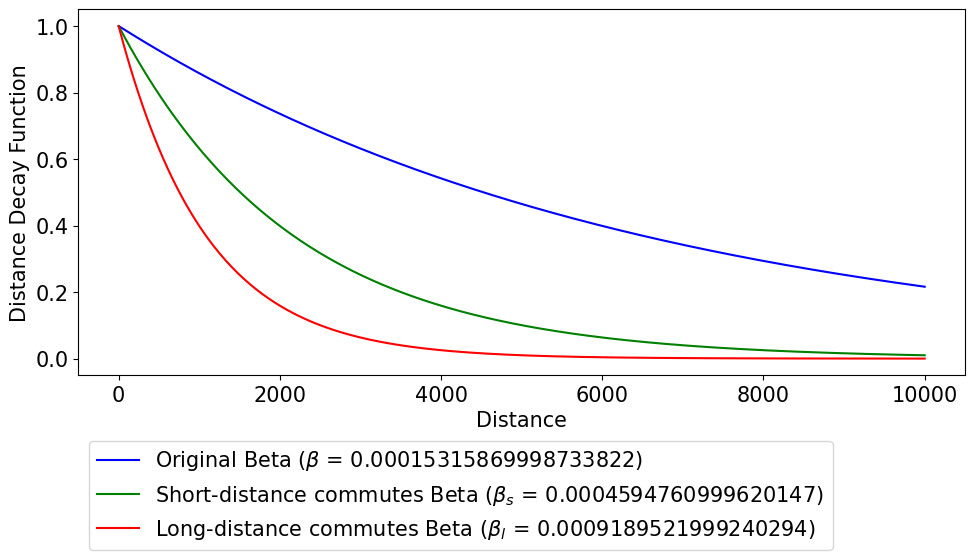

In [124]:
distances = np.linspace(1, 10000, 400)

f_dij_beta_2 = np.exp(-beta_2 * distances)
f_dij_beta_s = np.exp(-beta_s * distances)
f_dij_beta_l = np.exp(-beta_l * distances)

plt.figure(figsize=(10, 6))
plt.plot(distances, f_dij_beta_2, label=f'Original Beta ($\\beta$ = {beta_2})', color='blue')
plt.plot(distances, f_dij_beta_s, label=f'Short-distance commutes Beta ($\\beta_s$ = {beta_s})', color='green')
plt.plot(distances, f_dij_beta_l, label=f'Long-distance commutes Beta ($\\beta_l$ = {beta_l})', color='red')

plt.xlabel('Distance')
plt.ylabel('Distance Decay Function')
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15))

plt.tight_layout()
plt.savefig("outputs/Beta.png", format='png', dpi=300, bbox_inches='tight')

plt.show()

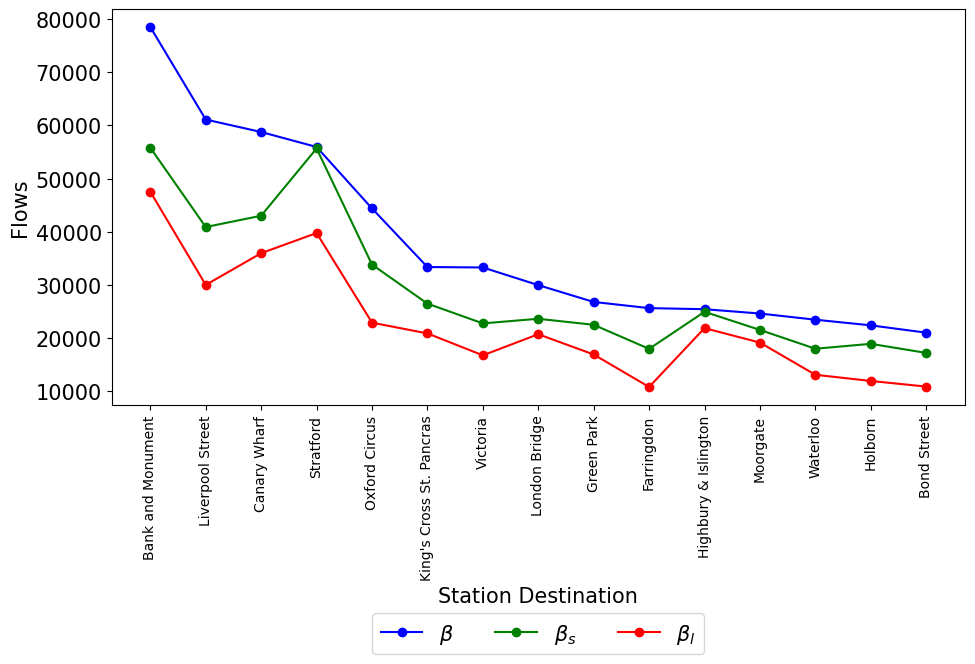

In [123]:
top15_df = df_compare.head(15).drop(columns=['Scenario A'])

ax = top15_df.plot(kind='line', figsize=(10, 8), marker='o')  

ax.lines[0].set_color('blue')
ax.lines[0].set_label(r'$\beta$')
ax.lines[1].set_color('green')
ax.lines[1].set_label(r'$\beta_s$')
ax.lines[2].set_color('red')
ax.lines[2].set_label(r'$\beta_l$')

plt.xticks(ticks=range(len(top15_df)), labels=top15_df.index, rotation=45)

plt.xlabel('Station Destination')
plt.ylabel('Flows')
plt.xticks(rotation=90, fontsize=10) 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)
plt.tight_layout() 
plt.savefig("outputs/Top15.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

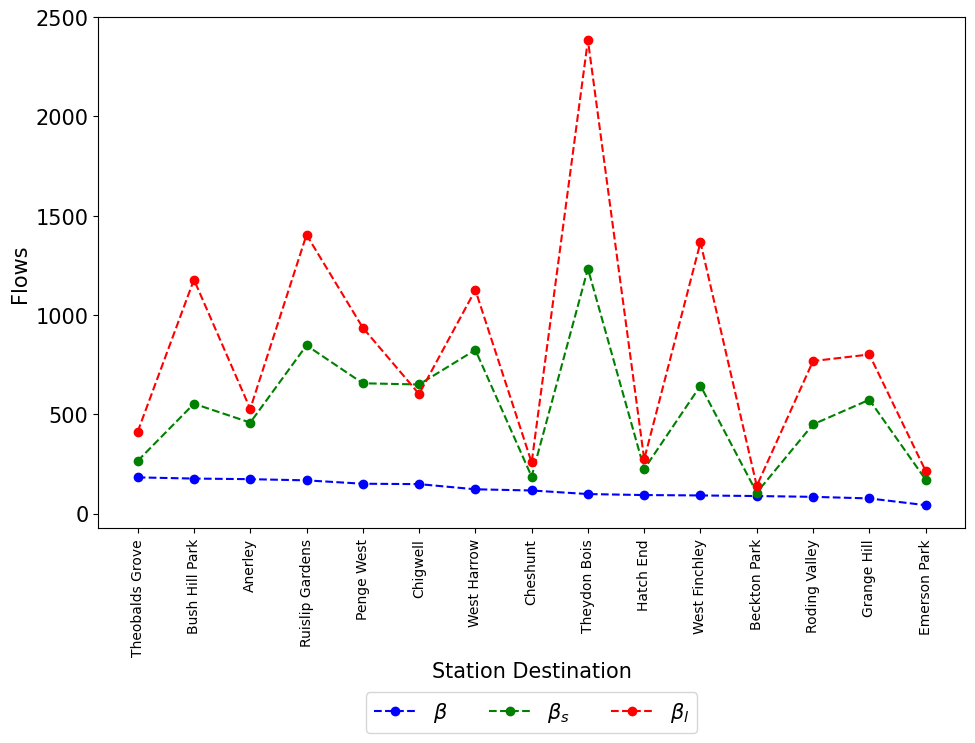

In [121]:
last15_df = df_compare.iloc[-16:-1].drop(columns=['Scenario A'])

ax = last15_df.plot(kind='line', figsize=(10, 8), marker='o')

ax.lines[0].set_color('blue')
ax.lines[0].set_label(r'$\beta$')
ax.lines[0].set_linestyle('--') 

ax.lines[1].set_color('green')
ax.lines[1].set_label(r'$\beta_s$')
ax.lines[1].set_linestyle('--') 

ax.lines[2].set_color('red')
ax.lines[2].set_label(r'$\beta_l$')
ax.lines[2].set_linestyle('--') 

plt.xticks(ticks=range(len(last15_df)), labels=last15_df.index, rotation=45)

plt.xlabel('Station Destination')
plt.ylabel('Flows')
plt.xticks(rotation=90, fontsize=10)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()
plt.savefig("outputs/Last15.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [86]:
G = nx.read_graphml('./london.graph.xml')

In [87]:
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

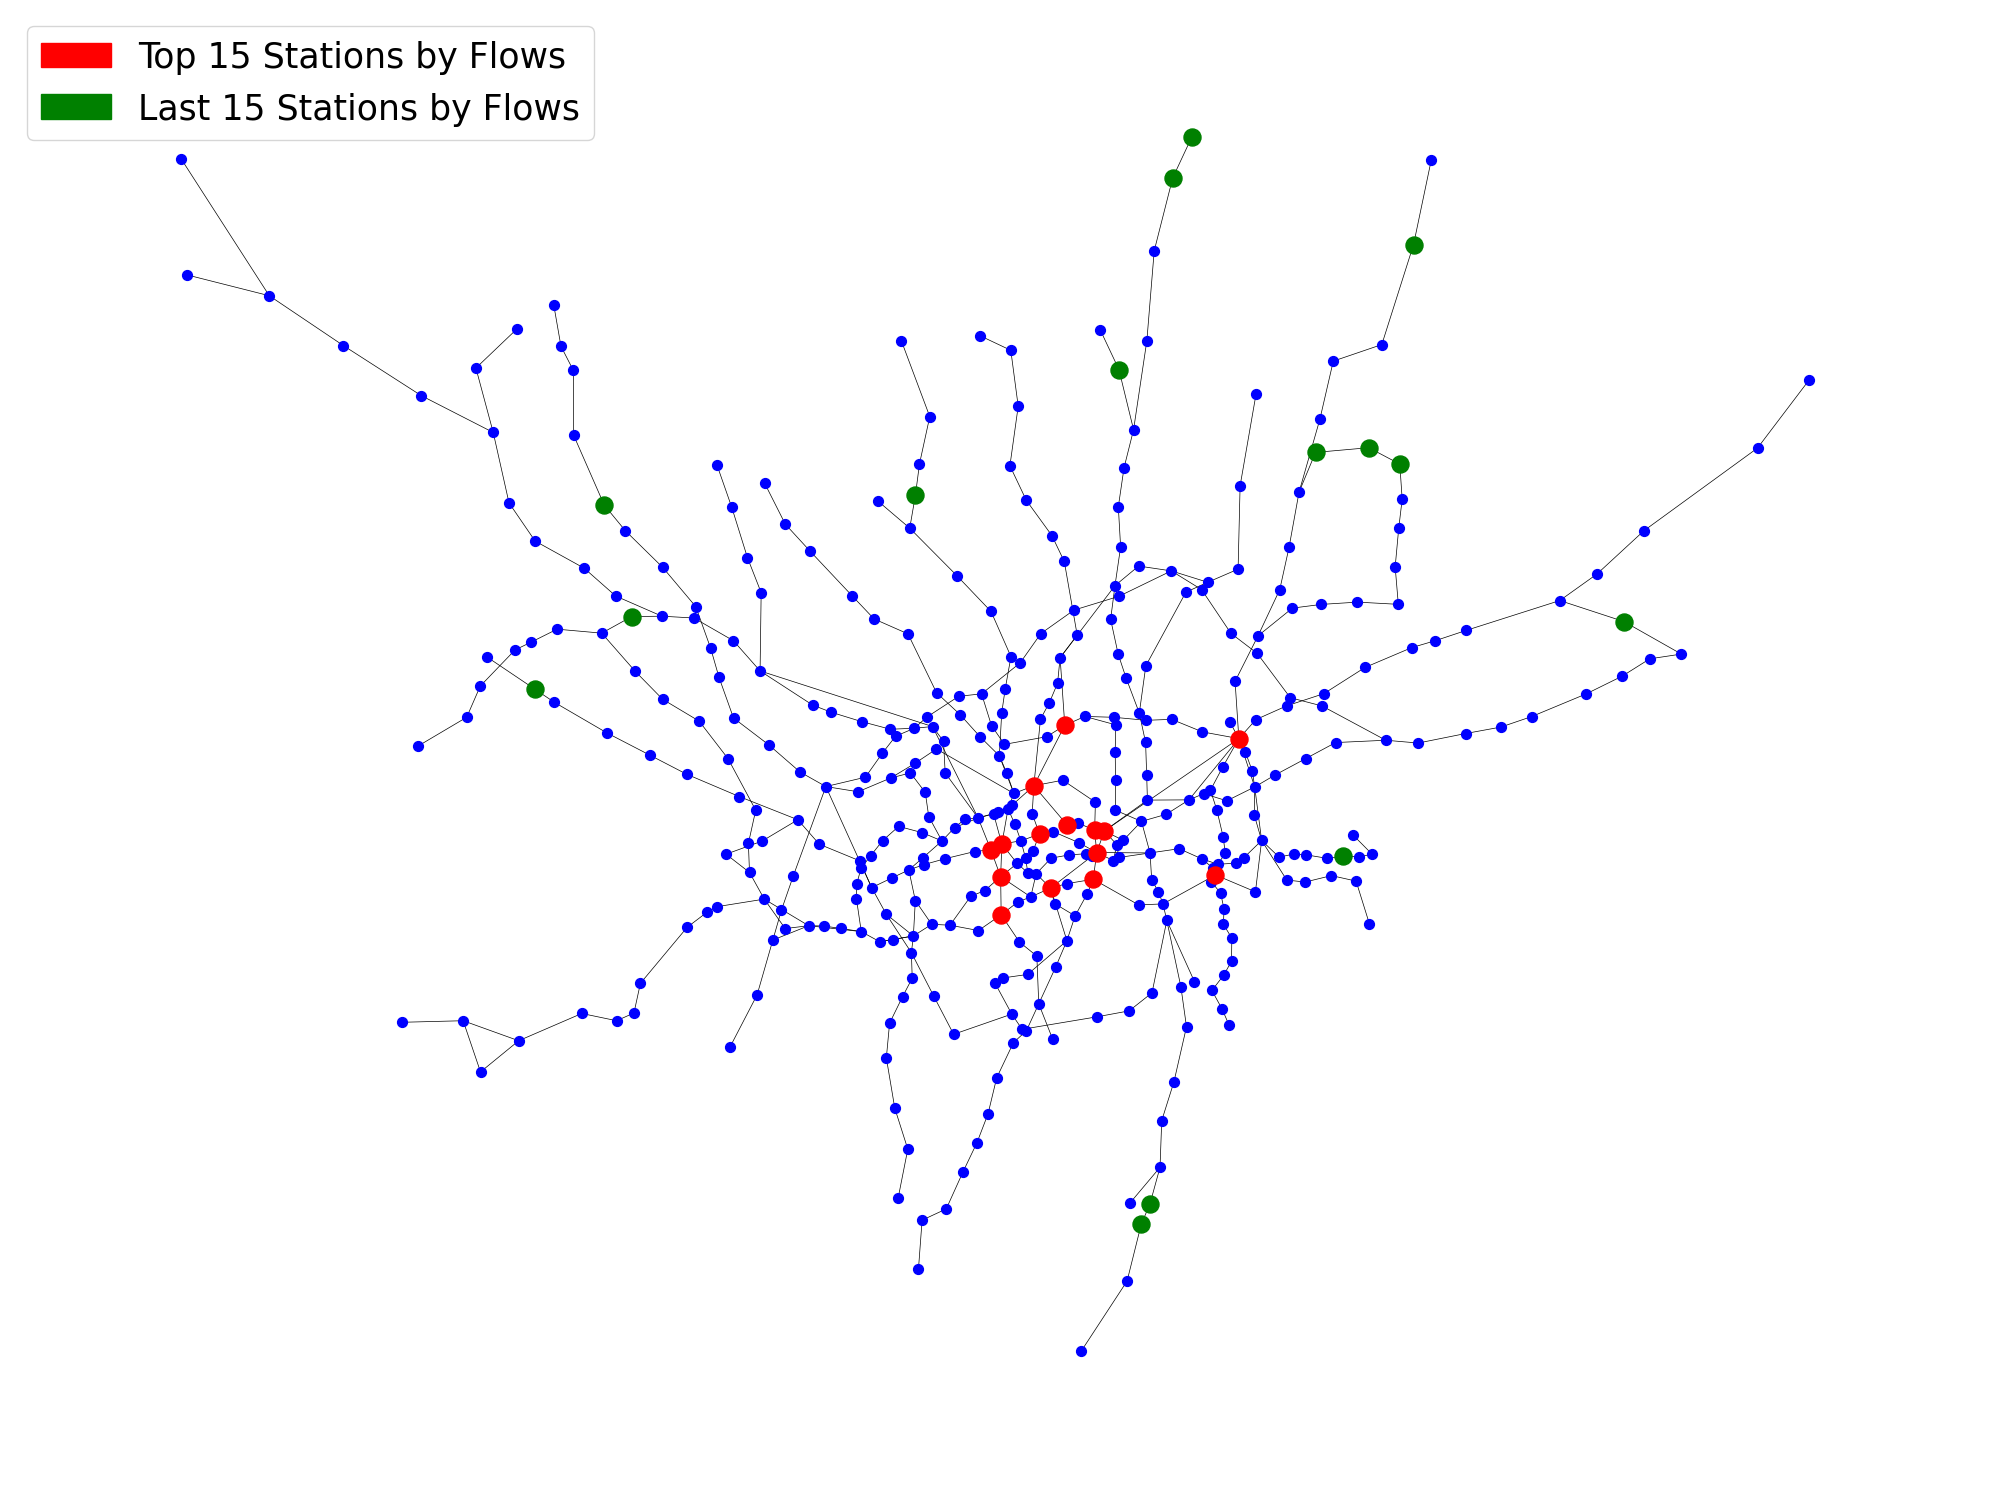

In [88]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(20,15))

# 获取节点的位置信息
pos = nx.get_node_attributes(G, 'coords')

# 绘制所有站点，但不显示站点名称
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
nx.draw_networkx_edges(G, pos, arrows=False, width=0.5)

# 最后15个站点列表
top_15_stations = ["Bank and Monument", "Liverpool Street", "Canary Wharf", "Stratford", "Oxford Circus",
                   "King's Cross St. Pancras", "Victoria", "London Bridge", "Green Park", "Farringdon",
                   "Highbury & Islington", "Moorgate", "Waterloo", "Holborn", "Bond Street"]
last_15_stations = ["Theobalds Grove", "Bush Hill Park", "Anerley", "Ruislip Gardens", "Penge West",
                    "Chigwell", "West Harrow", "Cheshunt", "Theydon Bois", "Hatch End", 
                    "West Finchley", "Beckton Park", "Roding Valley", "Grange Hill", "Emerson Park"]

# 确定哪些节点属于前15个站点和后15个站点
top_15_nodes = [node for node in G.nodes() if node in top_15_stations]
last_15_nodes = [node for node in G.nodes() if node in last_15_stations]

# 绘制前15个站点为红色，后15个站点为绿色，同时将节点稍微放大
nx.draw_networkx_nodes(G, pos, nodelist=top_15_nodes, node_size=150, node_color='red')
nx.draw_networkx_nodes(G, pos, nodelist=last_15_nodes, node_size=150, node_color='green')

red_patch = mpatches.Patch(color='red', label='Top 15 Stations by Flows')
green_patch = mpatches.Patch(color='green', label='Last 15 Stations by Flows')
plt.legend(handles=[red_patch, green_patch], loc='upper left', fontsize=25)
plt.tight_layout() 
plt.savefig("outputs/G_15.png", format='png', dpi=300, bbox_inches='tight')
plt.axis("off")
plt.show()

In [89]:
log_df_compare = df_compare.applymap(lambda x: np.log(x) if x > 0 else np.nan)

/tmp/ipykernel_193/1590596379.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_df_compare = df_compare.applymap(lambda x: np.log(x) if x > 0 else np.nan)


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

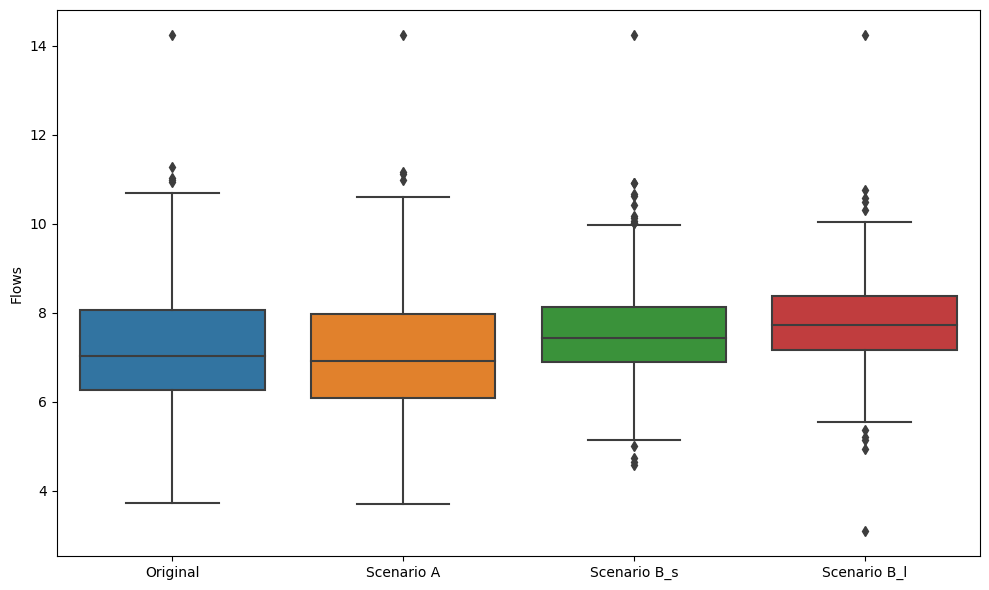

In [90]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=log_df_compare)
plt.ylabel('Flows')
plt.tight_layout()
plt.savefig("outputs/boxplot.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

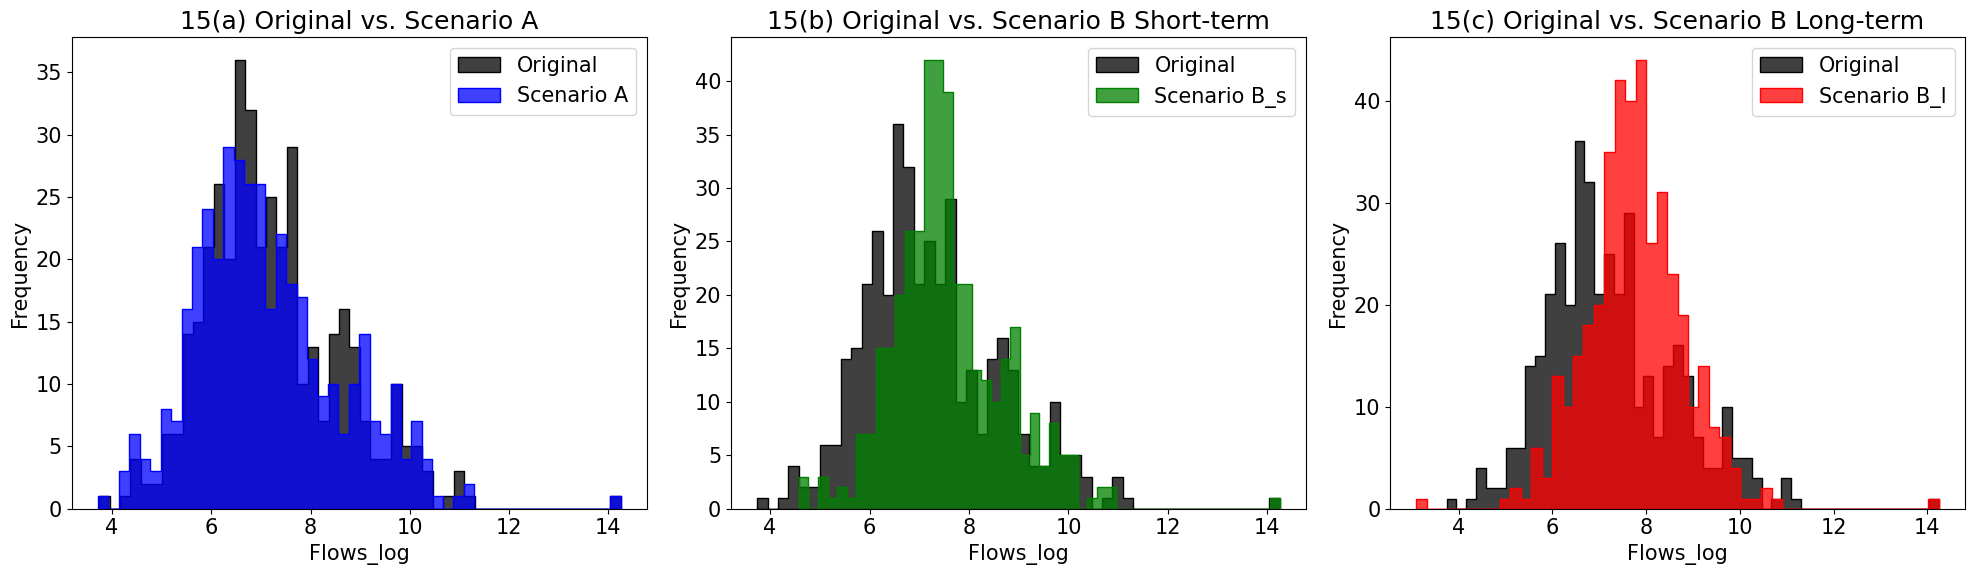

In [106]:
plt.rcParams.update({'font.size': 15})  # 可以根据需要调整字体大小
# Set up the figure and subplots with adjusted layout
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))  # Adjusted grid of subplots
axs = axs.flatten()  # Flatten the array for easier indexing
color_palette = ['black', 'blue', 'green', 'red']  # Updated colors for the scenarios, changed 'Job_Dec' to purple

# Plot comparisons in the first three subplots on the top row
comparison_pairs = [('Original', 'Scenario A'), ('Original', 'Scenario B_s'), ('Original', 'Scenario B_l')]
titles = [
    '15(a) Original vs. Scenario A',
    '15(b) Original vs. Scenario B Short-term',
    '15(c) Original vs. Scenario B Long-term'
]
for i, (primary, secondary) in enumerate(comparison_pairs):
    sns.histplot(log_df_compare[primary], color='black', label=primary, bins=50, ax=axs[i], element='step')
    sns.histplot(log_df_compare[secondary], color=color_palette[i+1], label=secondary, bins=50, ax=axs[i], element='step')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Flows_log')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

# Adjust layout and save/show the plot
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig('outputs/Comparison_of_Scenarios_his.png', dpi=300, bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

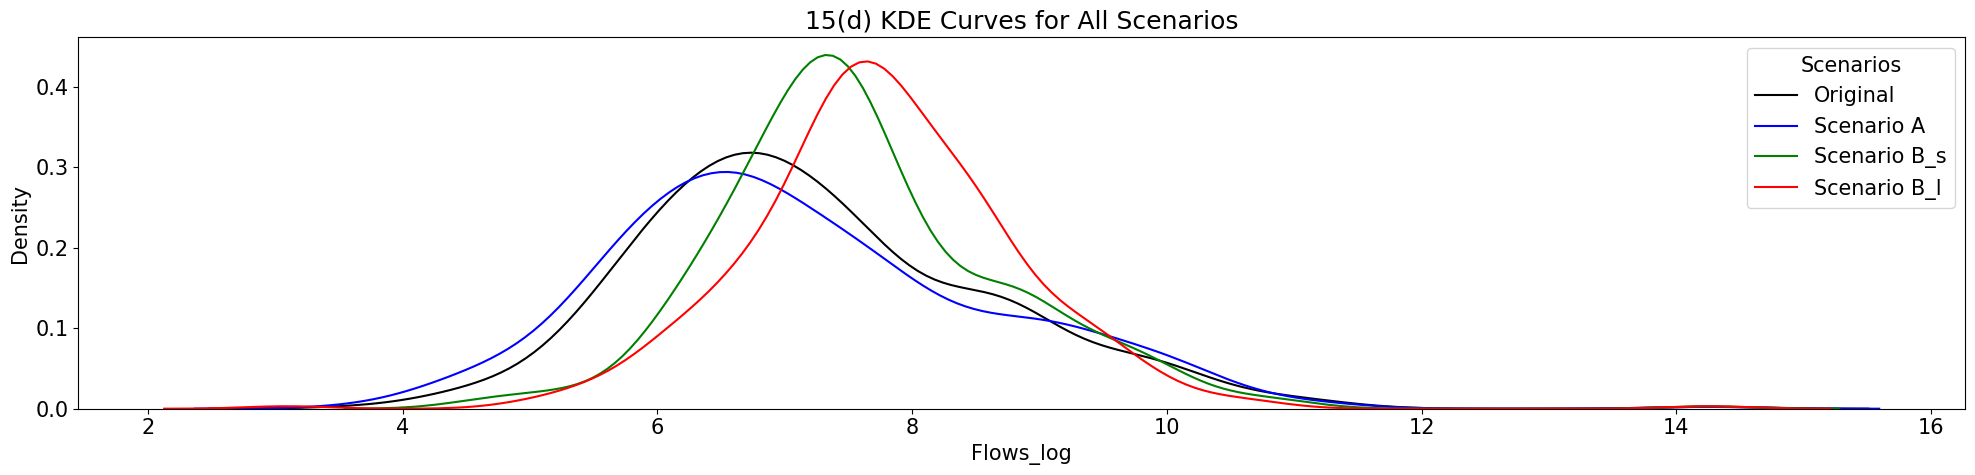

In [108]:
fig, ax = plt.subplots(figsize=(20, 5))

color_palette = ['black', 'blue', 'green', 'red']

for i, column in enumerate(log_df_compare.columns):
    sns.kdeplot(log_df_compare[column], color=color_palette[i], label=column, ax=ax, fill=False, common_norm=False)  # 设置 fill=False

ax.set_facecolor('white')

ax.set_title('15(d) KDE Curves for All Scenarios')
ax.set_xlabel('Flows_log')
ax.set_ylabel('Density')

plt.legend(title='Scenarios')

plt.tight_layout()
plt.savefig('outputs/Comparison_of_Scenarios_KDE.png', dpi=300, bbox_inches='tight')
plt.show()

In [110]:
skewness = log_df_compare.skew()
kurtosis = log_df_compare.kurtosis()

print("skewnes:\n", skewness)
print("kurtosis:\n", kurtosis)

skewnes:
 Original        0.747783
Scenario A      0.665936
Scenario B_s    0.857282
Scenario B_l    0.416214
dtype: float64
kurtosis:
 Original        1.265430
Scenario A      0.752527
Scenario B_s    2.811686
Scenario B_l    3.842406
dtype: float64
